<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_mirwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Mirwise based on Rishika's update to Rizwan**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [ ]:
!pip3 install umap-learn
!pip3 install hdbscan
!pip3 install lpips
!pip3 install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 586.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ff0542e828abecb1ed365f421c5e5c2ddd58cfe71d93070d2617179d2546bf70
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039292 sha256=ccb2801bafce1c0b3e6e9bd485844e409cb922133457ad58f154c48353e8466e
 

In [1]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.models import resnet18
from sklearn.decomposition import PCA
import umap
from umap import umap_ as UMAP
import lpips
from scipy.spatial.distance import pdist, squareform
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as SSIM
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS


import os
import json
from PIL import Image
from IPython.display import display
import torchvision.transforms as transforms

C:\Users\Mirwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [2]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [5]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [6]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [7]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [8]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Determine device to run on (GPU vs CPU)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Choose and Load dataset

In [10]:
dataset = ['Lego', 'NeRF'][1]
dataset

'NeRF'

### Based on chosen dataset, load Lego Truck dataset or real NeRF subjects
Please ensure the NeRF dataset is located in your drive and update the location of `dir` accordingly

https://drive.google.com/drive/folders/1JDdLGDruGNXWnM1eqY1FNL9PlStjaKWi

In [ ]:
# Download sample data used in the official tiny_nerf example
if dataset == 'Lego':
  if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
else:
  from google.colab import drive
  drive.mount('/content/drive')
  subjects = ['ship', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic']
  selected_subject = subjects[0]
  dir = f'/content/drive/MyDrive/BDRP/nerf_synthetic/{selected_subject}'

Mounted at /content/drive


In [43]:
dir = f'./data/nerf_synthetic/ship'

In [44]:
def get_focal_length(image_width, camera_angle_x):
  focal_length = image_width / (2 * np.tan(camera_angle_x / 2))
  return np.array([focal_length], dtype=np.float32)

In [45]:
def plot_camera_space(file_path, plot=True):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract camera positions from the transform matrices
    camera_positions = []
    images = []
    dir = file_path.replace('/transforms_train.json', '')

    for frame in data['frames']:
        transform_matrix = np.array(frame['transform_matrix'])
        # The camera position in homogeneous coordinates is the last column of the transform matrix
        camera_position = transform_matrix[:3, 3]
        camera_positions.append(camera_position)
        images.append(dir + frame['file_path'].replace('./', '/') + '.png')

    # Convert to a PyTorch tensor for easy manipulation
    camera_positions = torch.tensor(camera_positions)

    if plot:
        # Plotting the camera positions in 3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2], c='r', marker='o')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title('3D Camera Positions')

        plt.show()

    return camera_positions, images


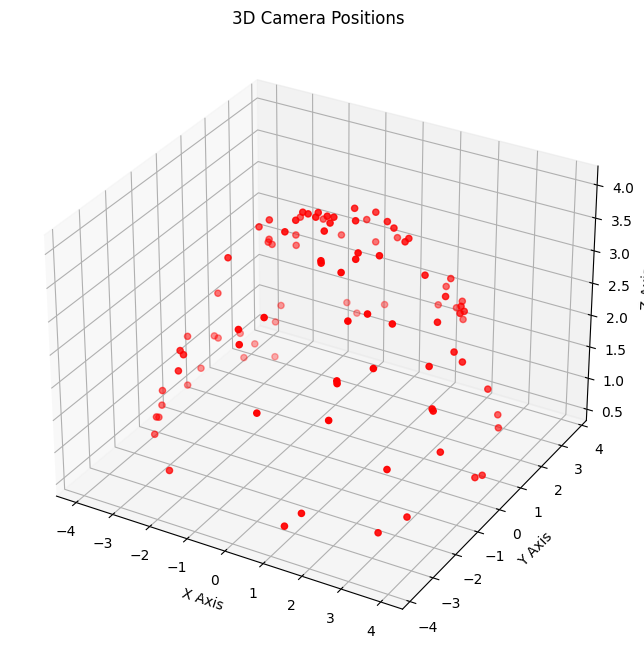

In [46]:
camera_positions, camera_images = plot_camera_space('./data/nerf_synthetic/ship/transforms_train.json')

In [47]:
def load_nerf_data(base_dir, json_file, skip_images=0):
    """
    Load NeRF data from real NeRF dataset

    Parameters:
    - base_dir (str): The base directory where the dataset is located.
    - json_file (str): The name of the JSON config file containing frame data.
    - skip_images (int, optional): The number of images to skip after processing an image.
      This is useful for reducing the dataset size. For example, in test dataset we want to
      reduce the size of 200 images to get 10 most diversified angle images
      Default is 0, which means no images are skipped.

    Returns:
    - images (numpy.ndarray): Array of loaded and processed images.
    - poses (numpy.ndarray): Array of camera poses corresponding to each image.
    - camera_angle_x (float): Horizontal field of view of the camera in radians.
    """

    # transform = transforms.Compose([transforms.ToTensor()])

    with open(os.path.join(base_dir, json_file), 'r') as f:
        data = json.load(f)

    camera_angle_x = data['camera_angle_x']
    images = []
    poses = []

    skip_counter = 0  # Counter for skipping images

    for frame in data['frames']:
        # Skip images with 'depth' or 'normal' in their file path
        if 'depth' in frame['file_path'] or 'normal' in frame['file_path']:
            continue

        # Process the image if skip_counter is 0, otherwise skip it
        if skip_counter == 0:
            # Load and process the image
            image_path = os.path.join(base_dir, frame['file_path'] + '.png')
            image = Image.open(image_path).convert("RGB")
            resized_image = image.resize((100, 100))
            images.append(TF.to_tensor(resized_image))

            # Extract camera pose
            pose = np.array(frame['transform_matrix'], dtype=np.float32)
            poses.append(pose)

            # Reset the skip_counter if an image was processed
            skip_counter = skip_images
        else:
            # Decrease the skip_counter since we're skipping this image
            skip_counter -= 1

    # Convert lists to numpy arrays
    images = torch.stack(images)
    poses = np.array(poses)
    images = images.permute(0, 2, 3, 1)

    return images, poses, camera_angle_x

#### Load up input images, poses, intrinsics, etc.

In [48]:
if dataset == 'Lego':
  # Load input images, poses, and intrinsics
  data = np.load("tiny_nerf_data.npz")

  # Images
  images = data["images"]
  # Camera extrinsics (poses)
  tform_cam2world = data["poses"]
  # Focal length (intrinsics)
  focal_length = data["focal"]
  focal_length
  focal_length = torch.from_numpy(focal_length).to(device)

  # Height and width of each image
  height, width = images.shape[1:3]

  # Near and far clipping thresholds for depth values.
  near_thresh = 2.
  far_thresh = 6.

  # Hold one image out (for test).
  testimgs, testposes = images[100:], tform_cam2world[100:]
  testimgs = torch.from_numpy(testimgs).to(device)
  testposes = torch.from_numpy(testposes).to(device)

  # Map images to device
  images = torch.from_numpy(images[:100, ..., :3]).to(device)
  tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)
else:
  # Load input images, poses, and intrinsics
  images, train_poses, camera_angle_x = load_nerf_data(dir, 'transforms_train.json')
  # print('Camera angle: ', camera_angle_x.float(), ' type: ', type(camera_angle_x.float()))

  tform_cam2world = train_poses

  # # Height and width of each image
  height, width = images.shape[1:3]

  focal_length = get_focal_length(width, camera_angle_x)
  focal_length = torch.from_numpy(focal_length).to(device)

  # # Near and far clipping thresholds for depth values.
  near_thresh = 2.
  far_thresh = 6.

  # Hold one image out (for test).
  testimgs, testposes, _ = load_nerf_data(dir, 'transforms_test.json', skip_images=20)

  testimgs = testimgs.to(device)
  testposes = torch.from_numpy(testposes).to(device)

  # # Map images to device
  images = images.to(device)
  tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

In [49]:
print('Train Images: ', images.shape)
print('Train Poses: ', tform_cam2world.shape)
print('Test Images: ', testimgs.shape)
print('Train Poses: ', testposes.shape)
print('Train Poses dtype: ', tform_cam2world[0].dtype)
print('Train Images dtype: ', images[0].dtype)

Train Images:  torch.Size([100, 100, 100, 3])
Train Poses:  torch.Size([100, 4, 4])
Test Images:  torch.Size([10, 100, 100, 3])
Train Poses:  torch.Size([10, 4, 4])
Train Poses dtype:  torch.float32
Train Images dtype:  torch.float32


In [ ]:
# # Image encoder
# class ImageEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.resnet = resnet18(pretrained=True).to(device)
#         self.resnet.eval()

#     def forward(self, x):
#         x = x.permute(0, 3, 1, 2)  # Adjust the dimensions to match [channels, batch_size, height, width]
#         x = self.resnet.conv1(x)
#         x = self.resnet.bn1(x)
#         feats1 = self.resnet.relu(x)
#         feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
#         feats3 = self.resnet.layer2(feats2)
#         feats4 = self.resnet.layer3(feats3)
#         latents = [feats1, feats2, feats3, feats4]
#         output_size = (100, 100)
#         for i in range(len(latents)):
#             latents[i] = F.interpolate(
#                 latents[i], output_size, mode="bilinear", align_corners=True
#             )
#         latents = torch.cat(latents, dim=1)
#         return latents

# # Identify optimal PCA dimension for all the images
# def converge_to_pca_dimensions(embeddings_flattened, min_variance=0.75):
#     # Perform PCA for dimensionality reduction
#     pca = PCA()
#     pca.fit(embeddings_flattened)

#     # Calculate explained variance ratio and cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cum_explained_var = np.cumsum(explained_var_ratio)

#     # Find the number of components that explain the specified variance
#     n_components = np.argmax(cum_explained_var >= min_variance) + 1

#     if n_components > 100:
#       print('Max number of components reached..\n')
#       n_components = 100

#     # Retrain PCA with the selected number of components
#     pca = PCA(n_components=n_components)
#     dim_reduction = pca.fit_transform(embeddings_flattened)

#     print(f'Number of components: {n_components}\n')

#     return dim_reduction, pca.explained_variance_ratio_, n_components

# # Assuming 'images' is a NumPy array containing your images

# # Instantiate the ImageEncoder
# image_encoder = ImageEncoder()

# # Get the embeddings for the 100 images
# processed_images_tensor = torch.tensor(images).to(device)
# with torch.no_grad():
#     embeddings = image_encoder(processed_images_tensor)
# embeddings_flattened = embeddings.cpu().numpy().reshape(embeddings.shape[0], -1)

# # Calculate the optimal number of components for PCA
# target_variance = 0.95  # Adjust this as needed
# reduced_embeddings, explained_variance_ratio, n_components = converge_to_pca_dimensions(embeddings_flattened, target_variance)

# print(f"Optimal number of components to retain {target_variance} variance: {n_components}")

In [ ]:
# plt.figure(figsize=(5, 5))
# plt.plot(np.cumsum(explained_variance_ratio))
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance')
# plt.title('Explained Variance vs Number of Components')
# plt.grid(True)

# # Marking the line for variance = 0.44 and components = 5
# target_variance = 0.44
# target_components = 5
# variances = np.cumsum(explained_variance_ratio)
# plt.axvline(x=target_components, color='r', linestyle='--', label=f'Components: {target_components}')
# plt.axhline(y=target_variance, color='g', linestyle='--', label=f'Variance: {target_variance}')

# plt.legend()
# plt.show()

In [ ]:
# # Checking variance for n_components=5
# pca = PCA(n_components=5)
# dim_reduction = pca.fit_transform(embeddings_flattened)

# # Calculate explained variance ratio
# explained_var_ratio = pca.explained_variance_ratio_
# print(np.sum(explained_var_ratio))

#### Display the image used for testing

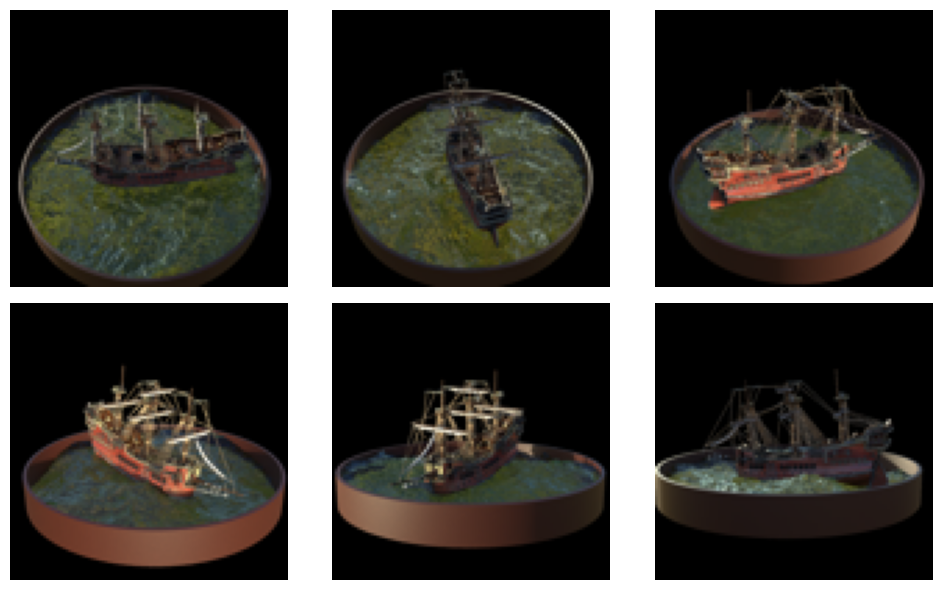

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), testimgs):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Train TinyNeRF!

(The cool part!)

In [51]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

# **Random Selection of Frames**


Frames Chosen by Random Frame Selection



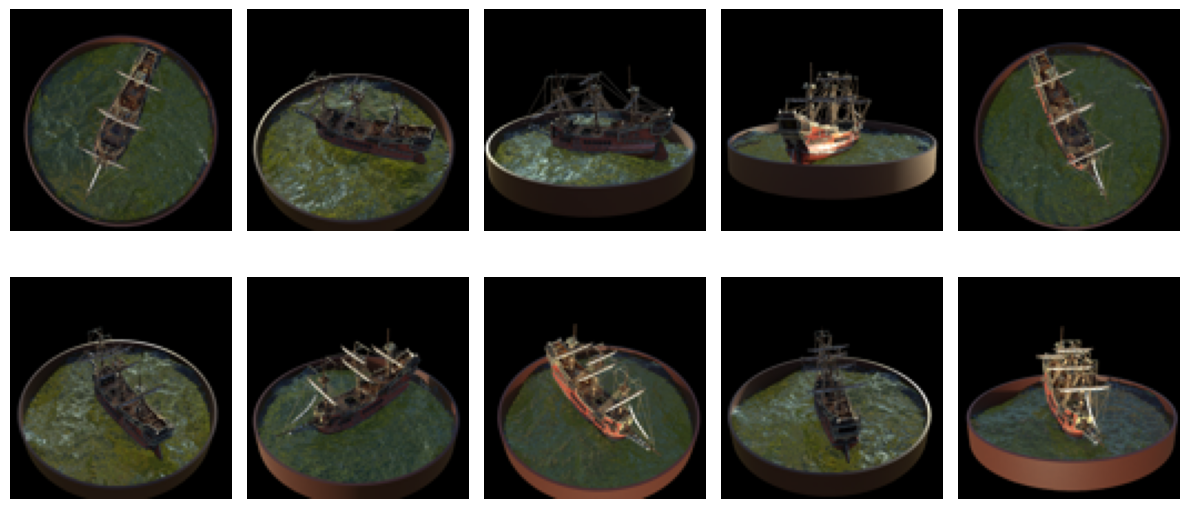

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 4000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

k = 10

# Shuffle the list of indices randomly
indices = list(range(images.shape[0]))

# Shuffle the list of indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into two parts: k for training and the rest for holdout
training_indices = indices[:k]
holdout_indices = indices[k:]

# Use the indices to split the images into training and holdout arrays
training_images = images[training_indices]
holdout_images = images[holdout_indices]

# Use the indices to split the transformation matrices into training and holdout arrays
training_tforms = tform_cam2world[training_indices]
holdout_tforms = tform_cam2world[holdout_indices]

print()
print("Frames Chosen by Random Frame Selection")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

### **Training for Random Frame Selection**

In [36]:
def calculate_lpips(img1, img2):
  # Function to calculate LPIPS
  lpips = LPIPS(net_type='alex').to(device) # The model used is Alex (lightweight)
  img1 = img1.permute(2, 0, 1).unsqueeze(0).to(device)
  img2 = img2.permute(2, 0, 1).unsqueeze(0).to(device)
  return lpips(img1, img2).item()

# Function to calculate SSIM using torchvision
def calculate_ssim(img1, img2):
    return SSIM(img1, img2, channel_axis=-1, data_range=1.0).item()

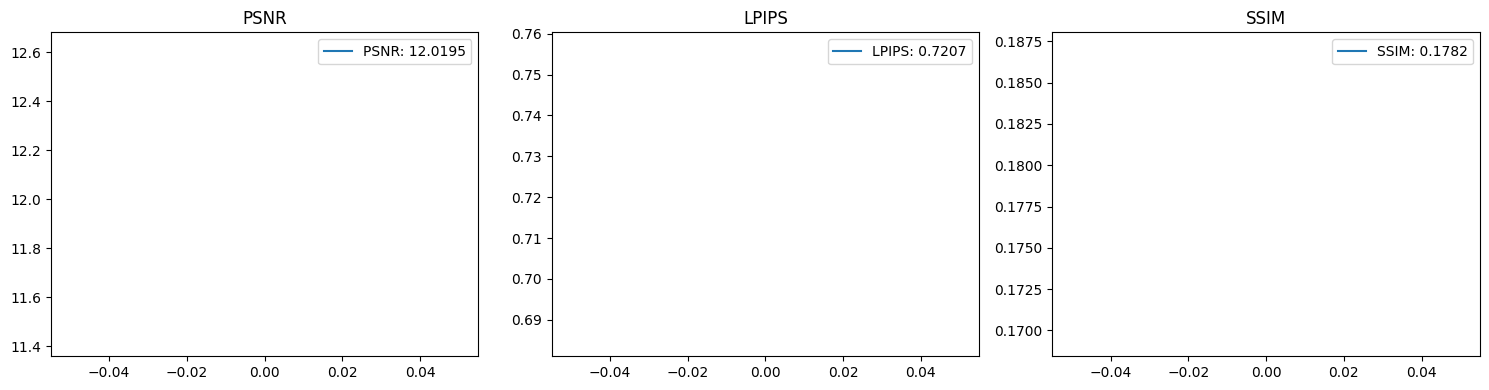

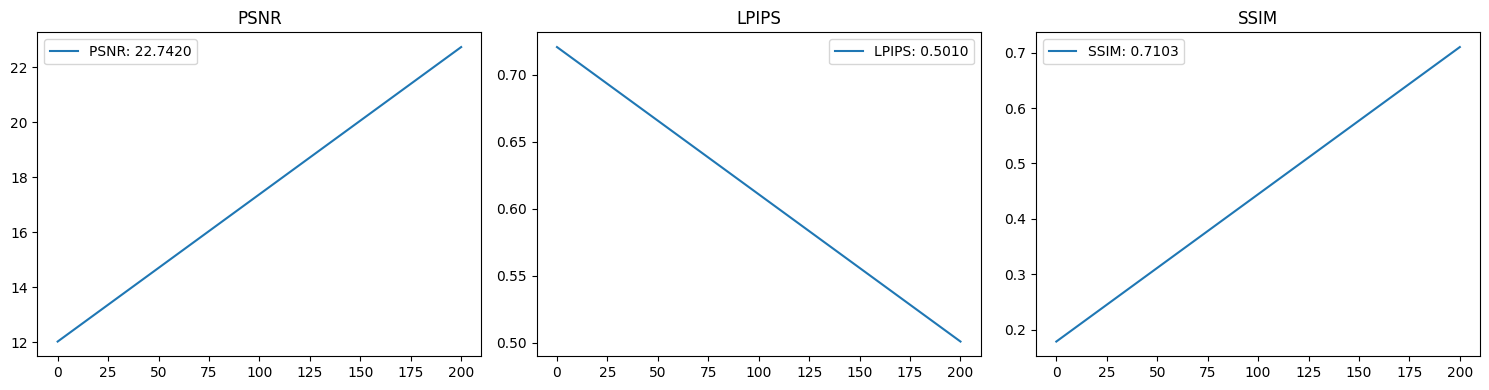

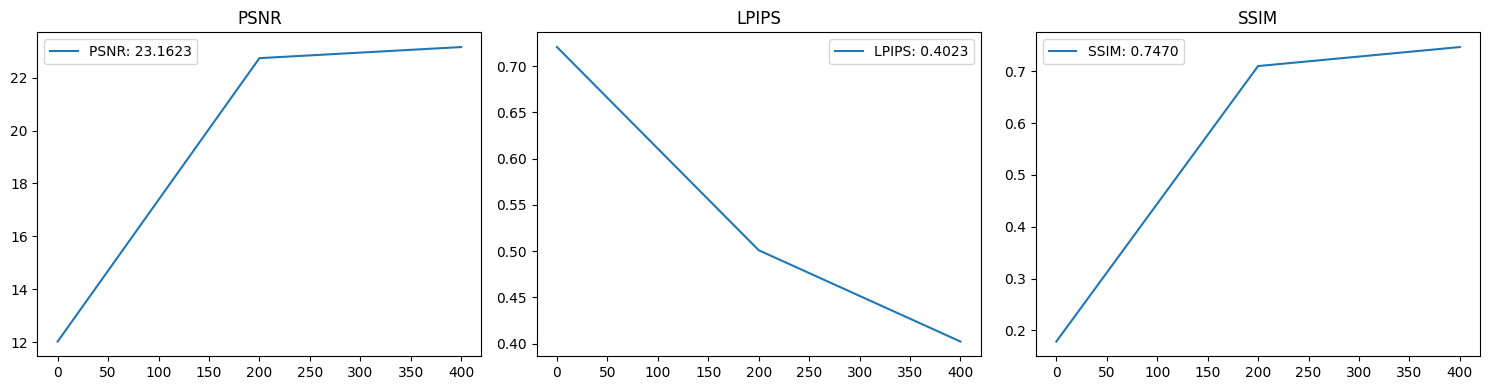

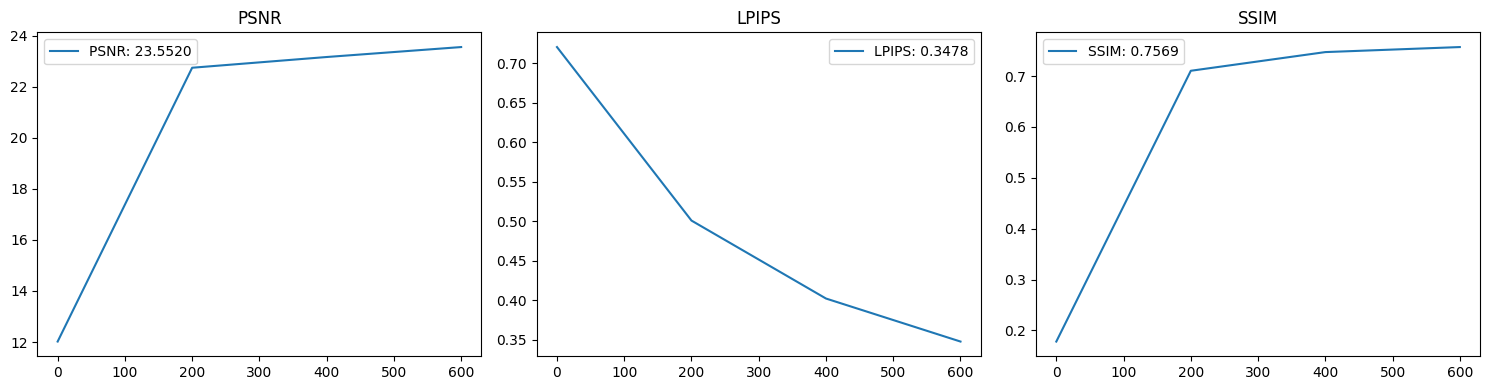

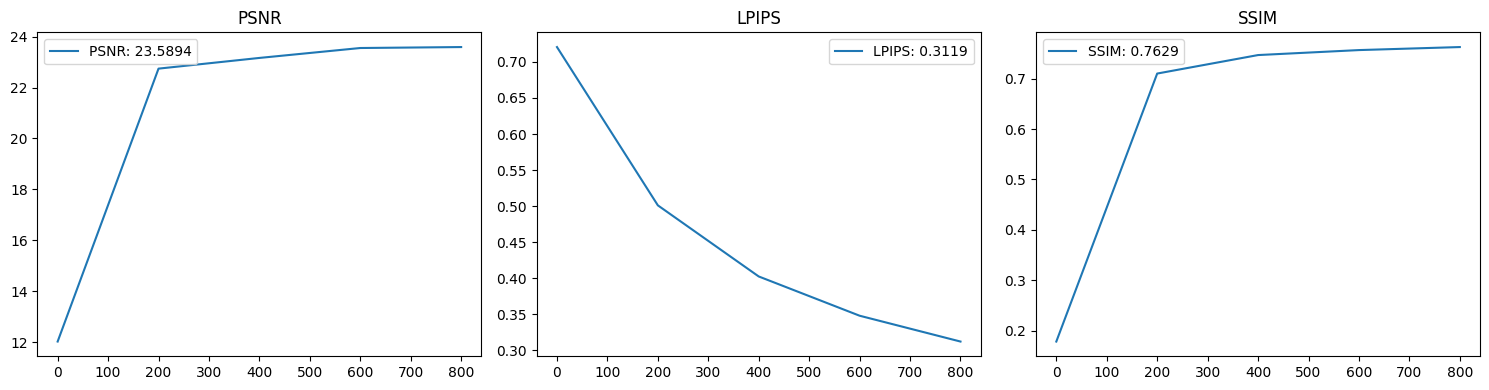

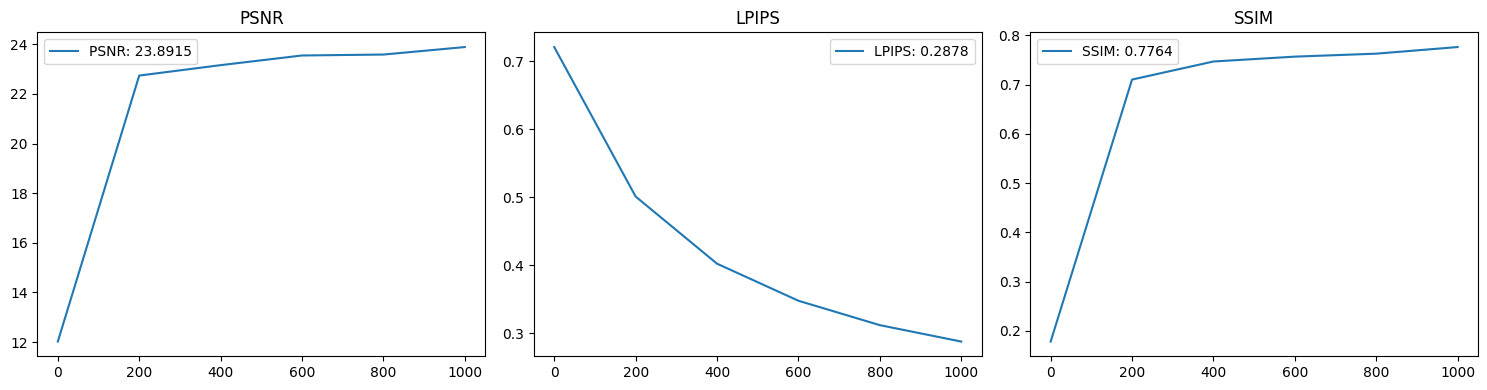

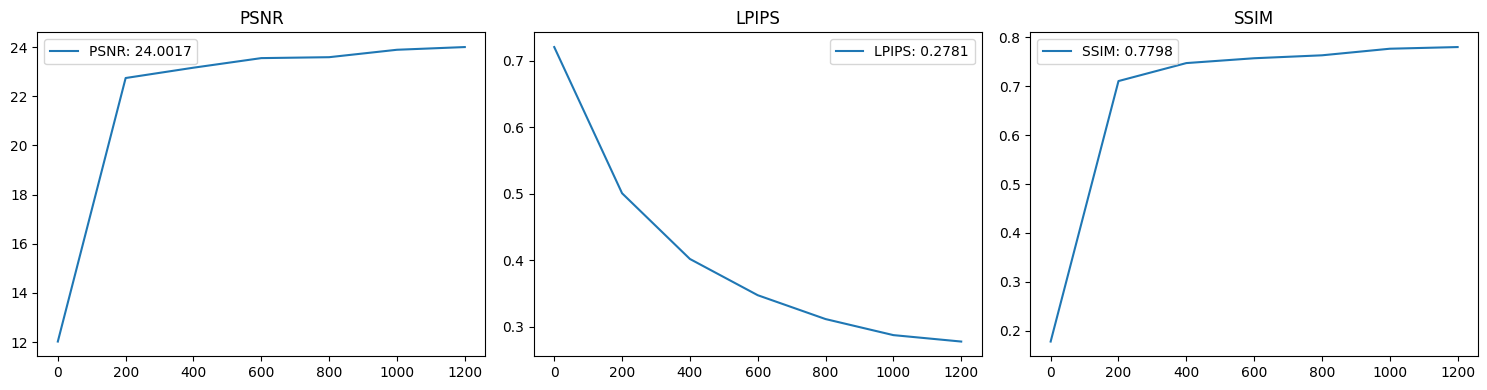

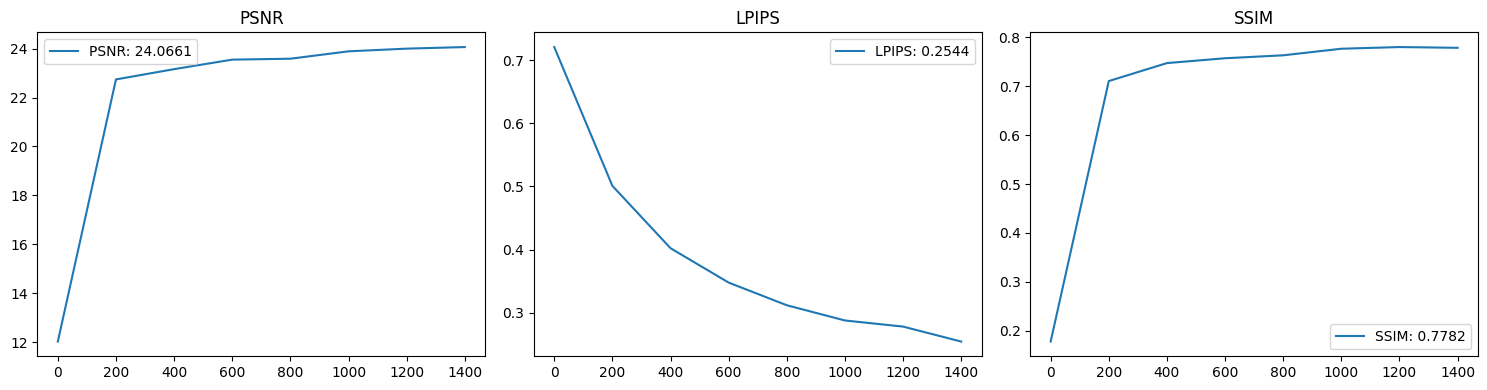

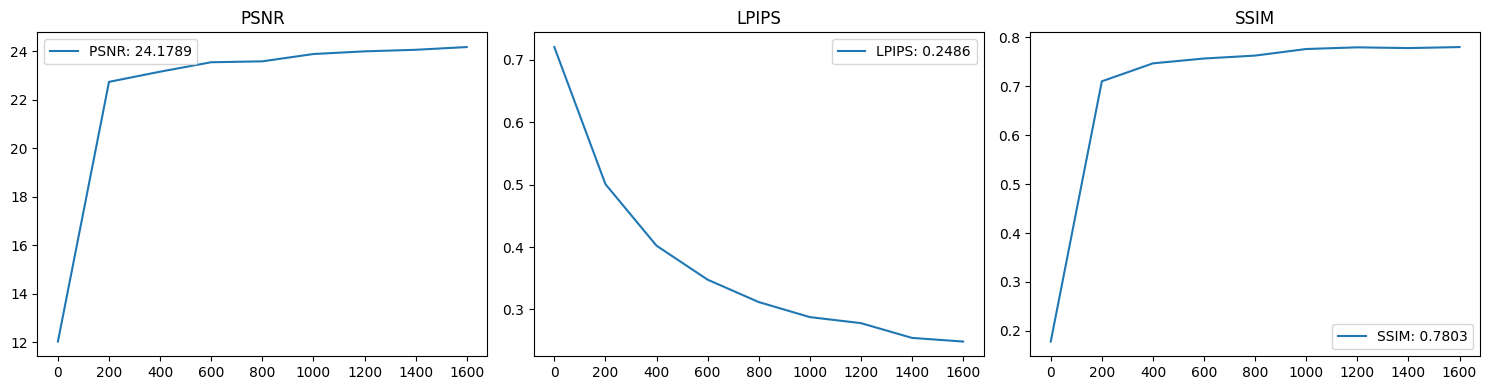

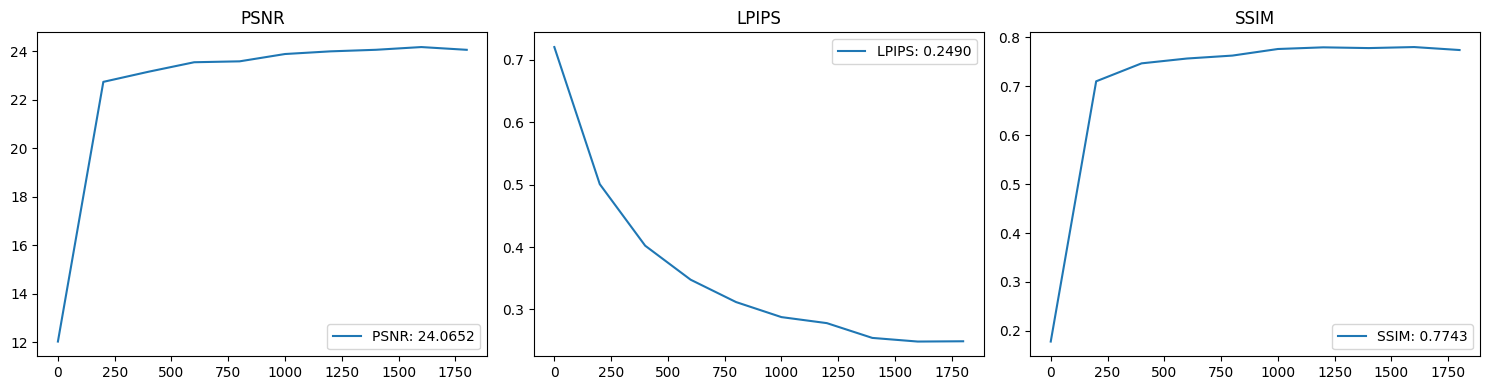

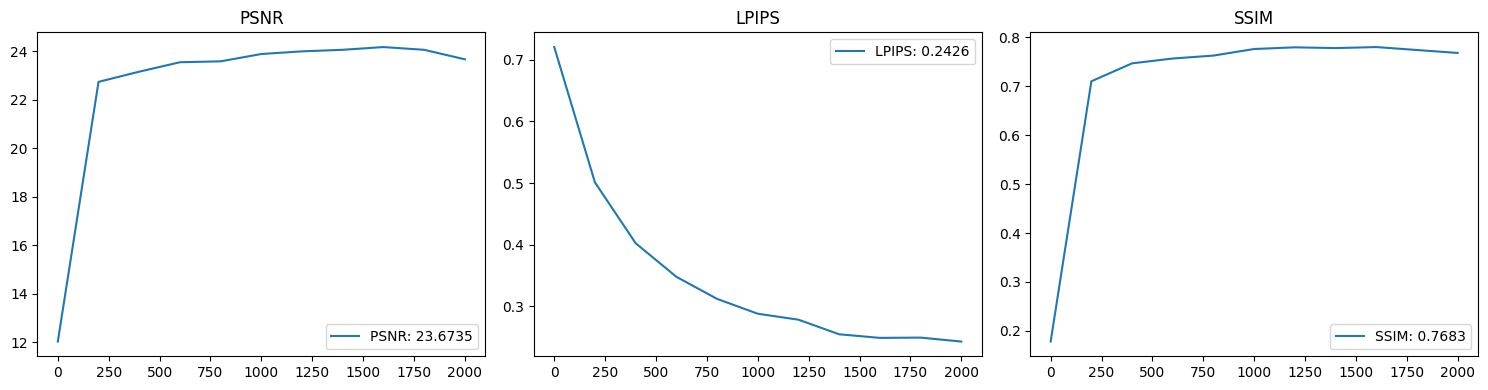

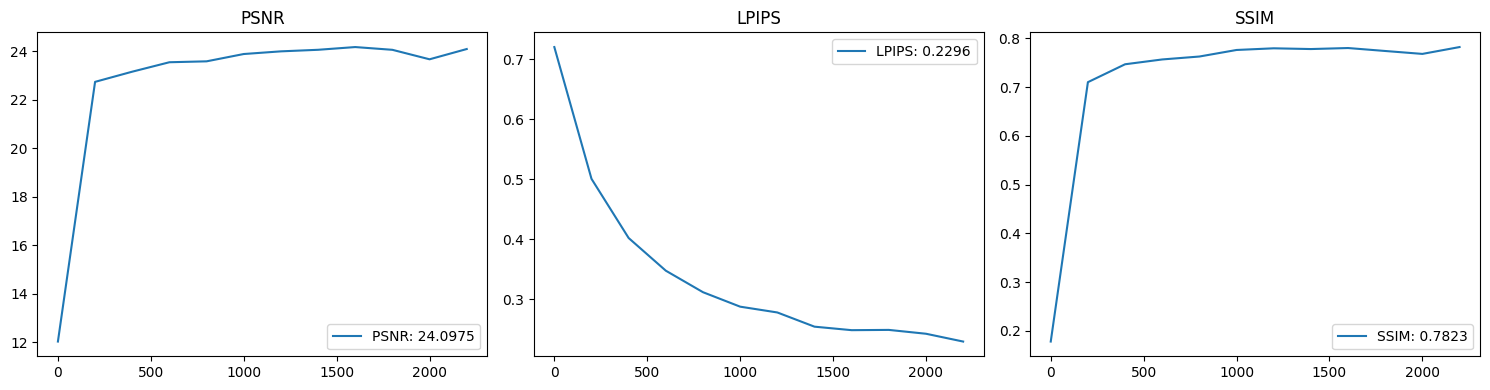

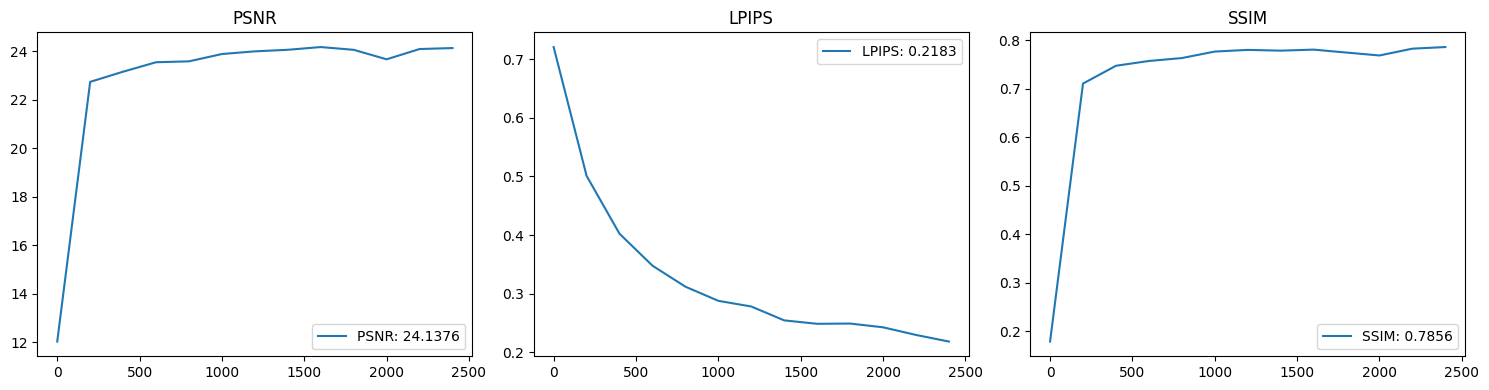

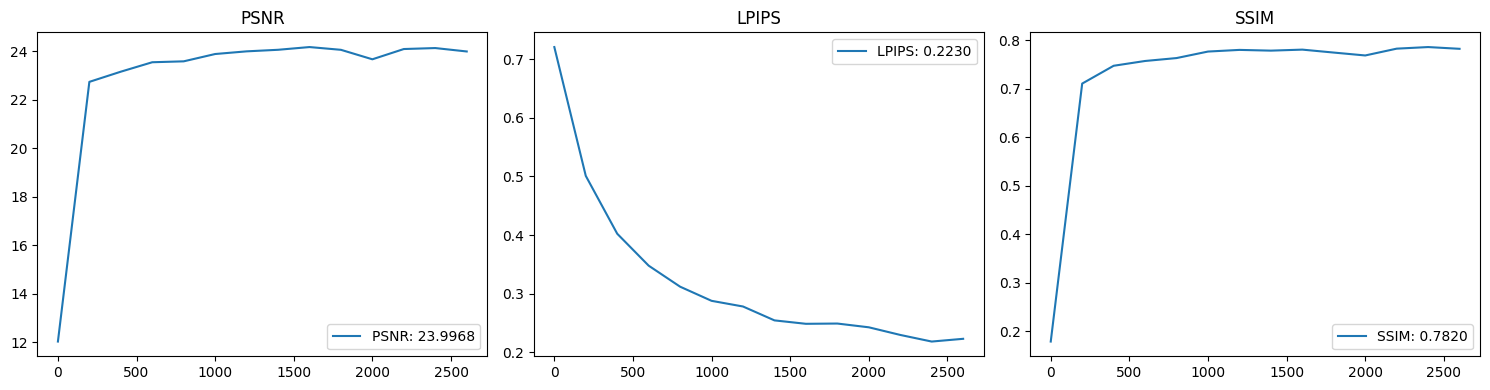

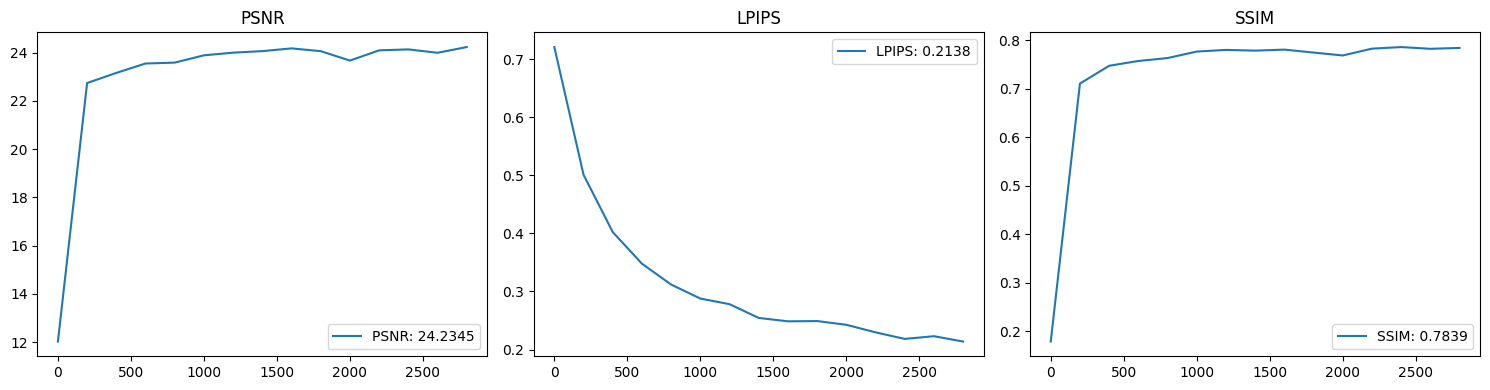

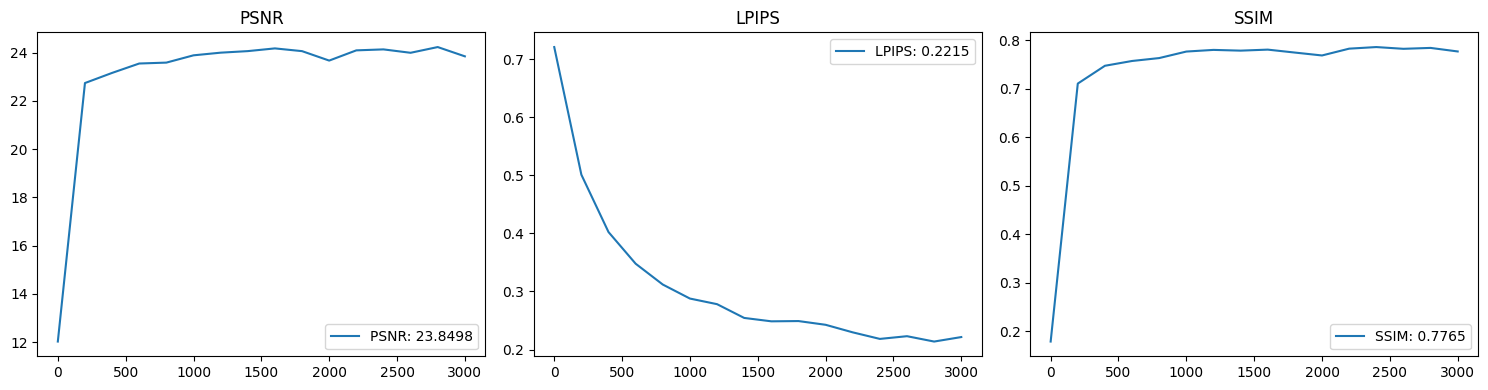

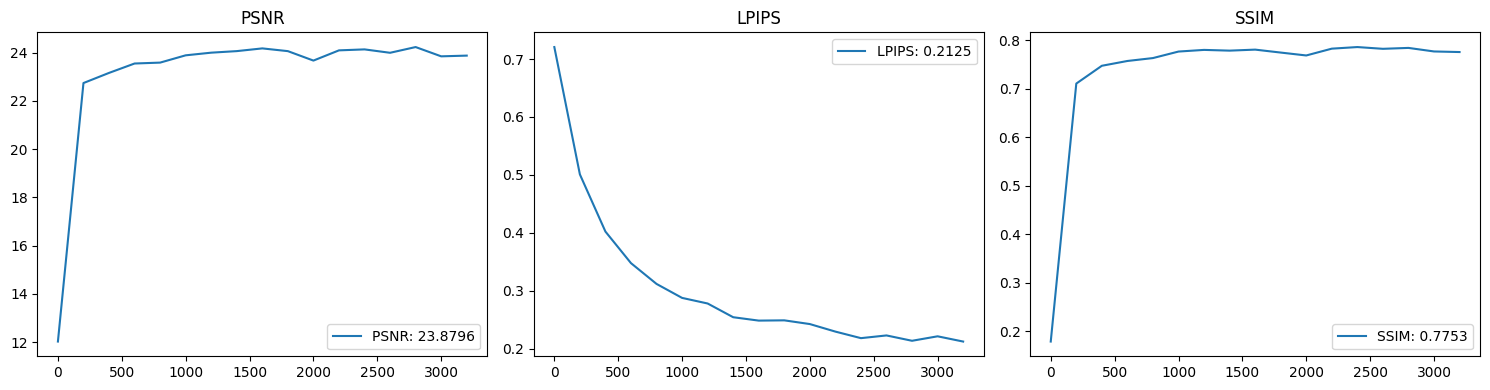

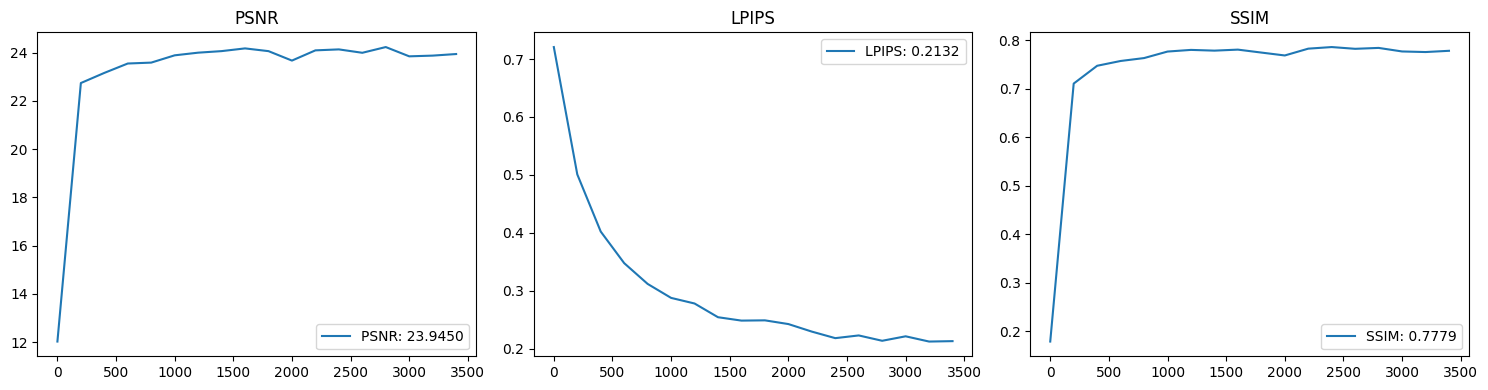

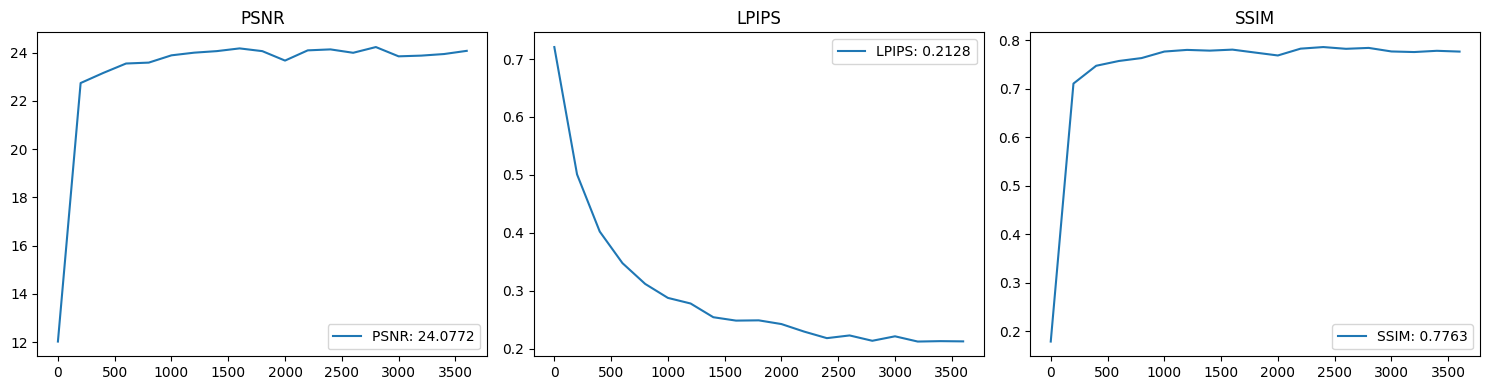

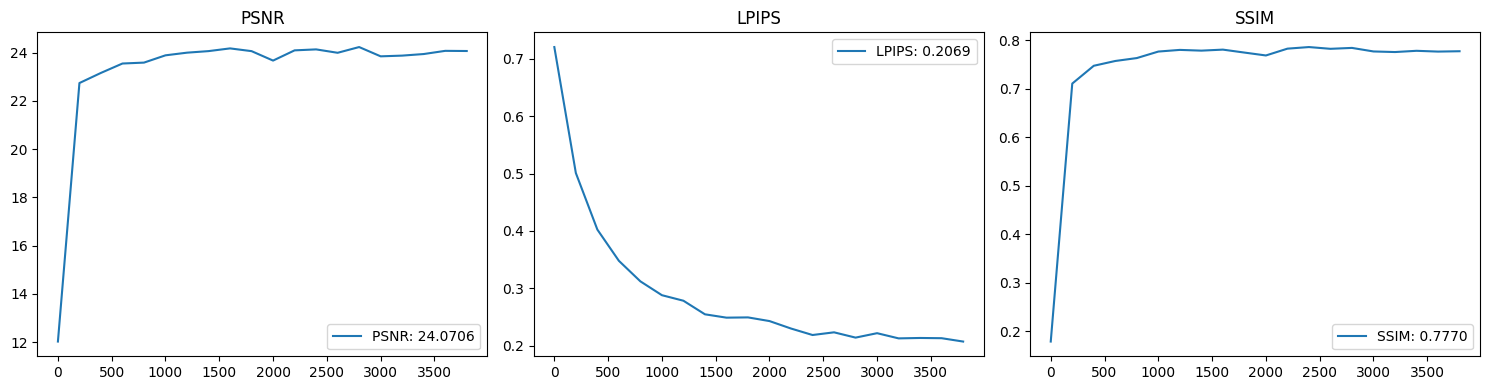

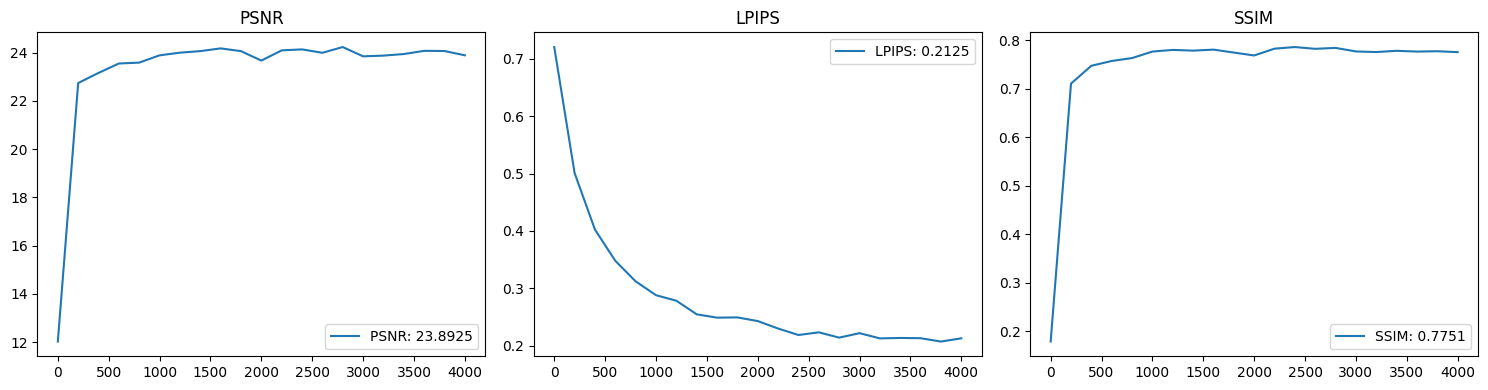

Done!


In [ ]:
# Lists to log metrics etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    avg_lpips = []
    avg_ssim = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

print('Done!')

In [ ]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

psnr: 23.89246883392334
lpips: 0.21254059225320815
ssim: 0.7751402974128723


Reconstructed Test Images


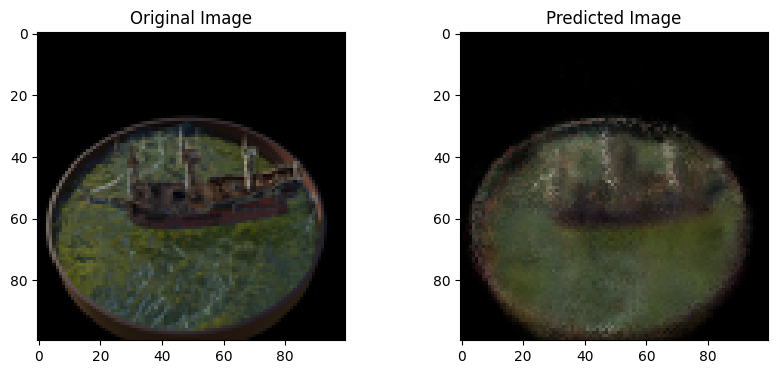

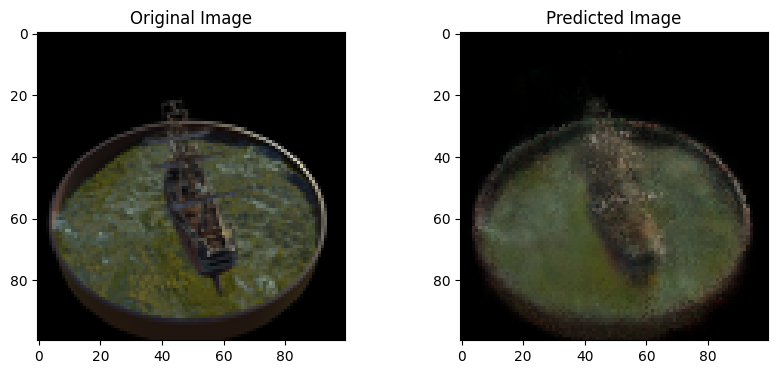

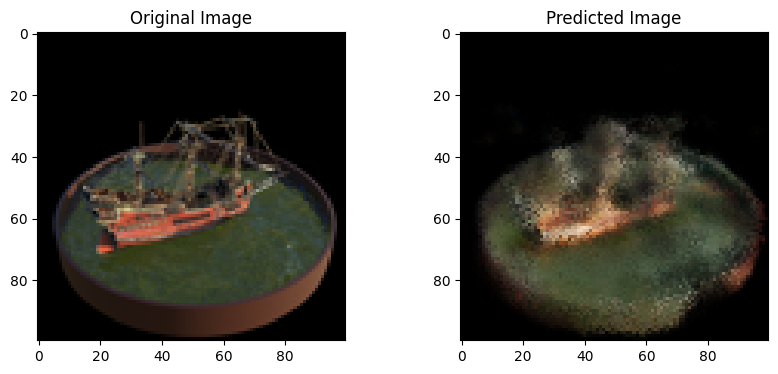

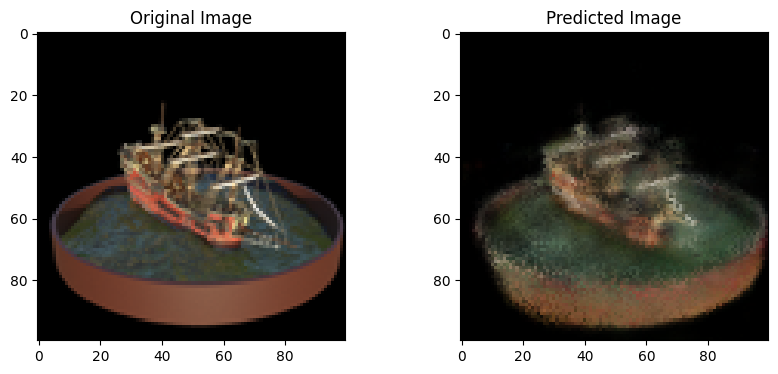

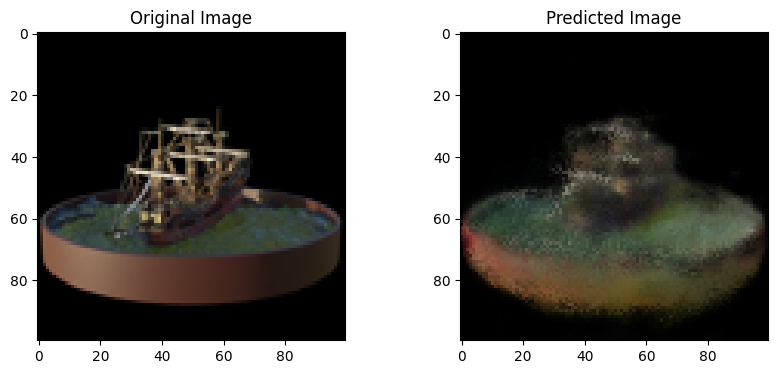

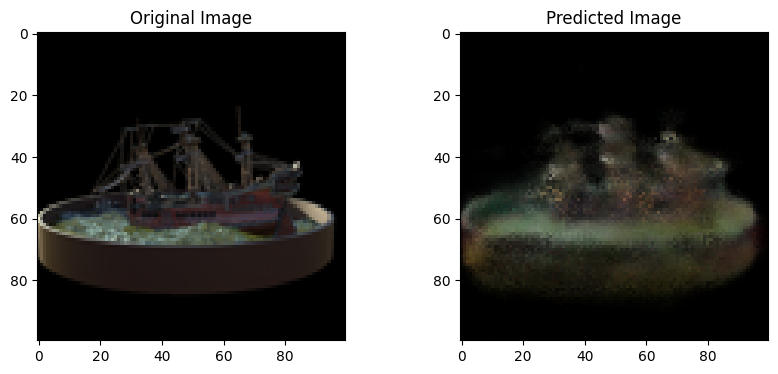

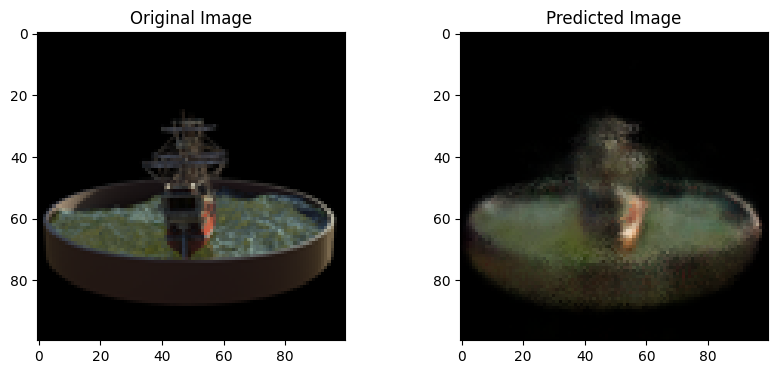

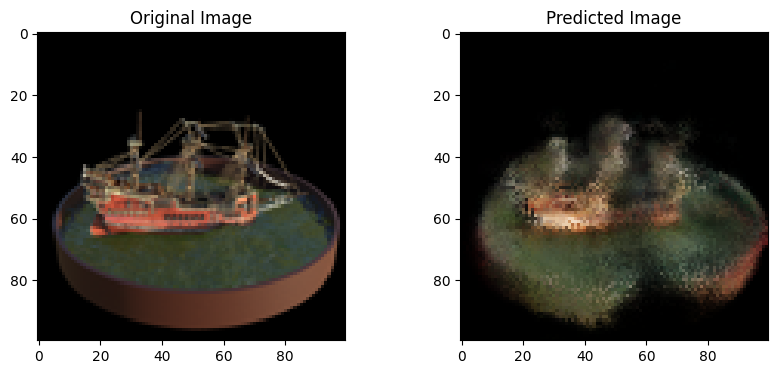

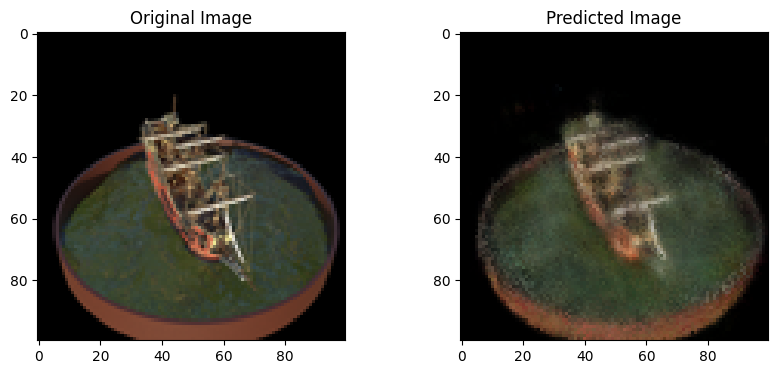

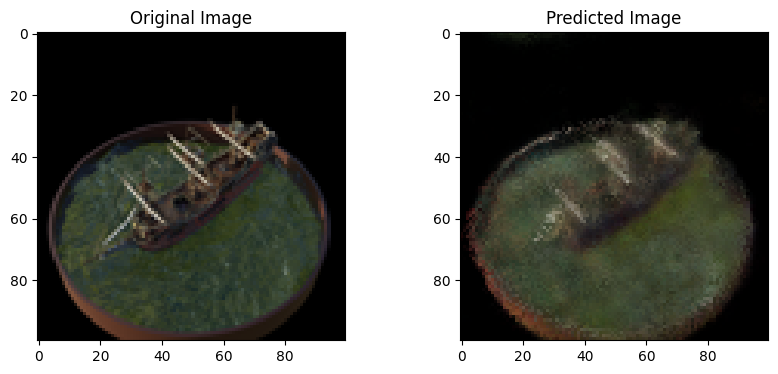

In [ ]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()

# **3D Space**

Number of clusters: 21


[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]

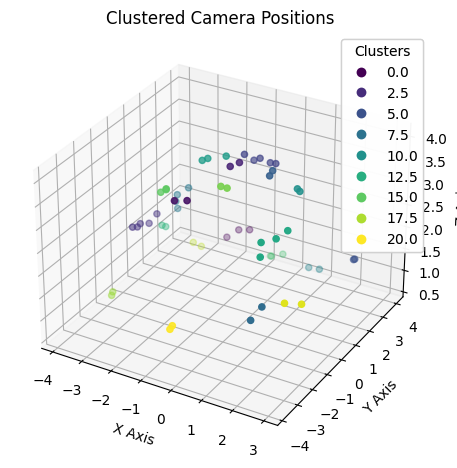

In [37]:
from sklearn.cluster import DBSCAN

# Convert to a NumPy array for compatibility with scikit-learn
camera_positions_np = camera_positions.numpy()

# Normalize the camera positions
scaler = StandardScaler()
camera_positions_normalized = scaler.fit_transform(camera_positions_np)

# Apply DBSCAN Clustering
# These parameters (eps and min_samples) might need to be adjusted for your specific data
dbscan = DBSCAN(eps=0.3, min_samples=2).fit(camera_positions_normalized)
labels = dbscan.labels_

# Count the number of unique clusters (excluding noise points)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters}")

# Filtering noise points (labelled as -1)
valid_labels = labels[labels != -1]
valid_positions = camera_positions_np[labels != -1]

# Plot the camera positions in 3D space, coloring them based on their cluster
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(211, projection='3d')
scatter = ax1.scatter(valid_positions[:, 0], valid_positions[:, 1], valid_positions[:, 2], c=valid_labels, cmap='viridis')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')
ax1.set_title('Clustered Camera Positions')
legend1 = ax1.legend(*scatter.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

# Plot the selected images in a 2-row grid beneath the 3D plot
# Selecting one image per cluster (if available)
selected_images_indices = []
for i in range(n_clusters):
    cluster_indices = np.where(valid_labels == i)[0]
    if len(cluster_indices) > 0:
        selected_images_indices.append(cluster_indices[0])  # Selecting the first image in each cluster

# Adjust number of images to plot to maximum 10
selected_images_indices = selected_images_indices[:10]
selected_images_indices



In [52]:
selected_images_indices = [2, 60, 43, 88, 42, 46, 83, 63, 76, 77]


Frames Chosen by Furthest View Sampling



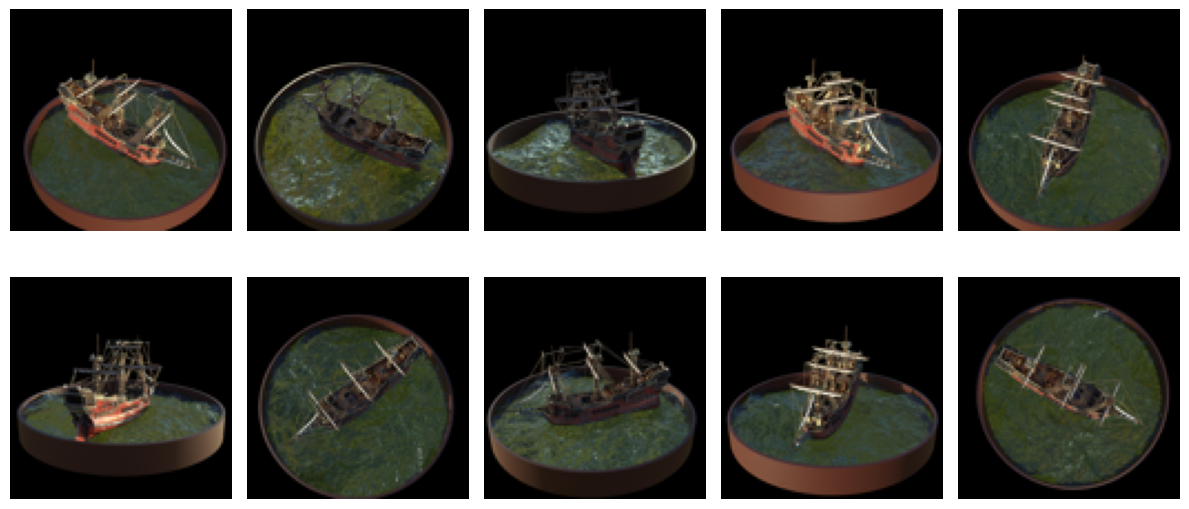

In [53]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 4000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

training_images = images[selected_images_indices]
training_tforms = tform_cam2world[selected_images_indices]

print()
print("Frames Chosen by Furthest View Sampling")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## **Training of Furthest View Sampling**

In [32]:
training_images.dtype

torch.float32

In [34]:
rgb_predicted_cpu = training_images[0]
max_val = max(rgb_predicted_cpu.max(), testimg_cpu.max())
min_val = min(rgb_predicted_cpu.min(), testimg_cpu.min())
data_range = max_val - min_val
print(data_range)


tensor(1.)


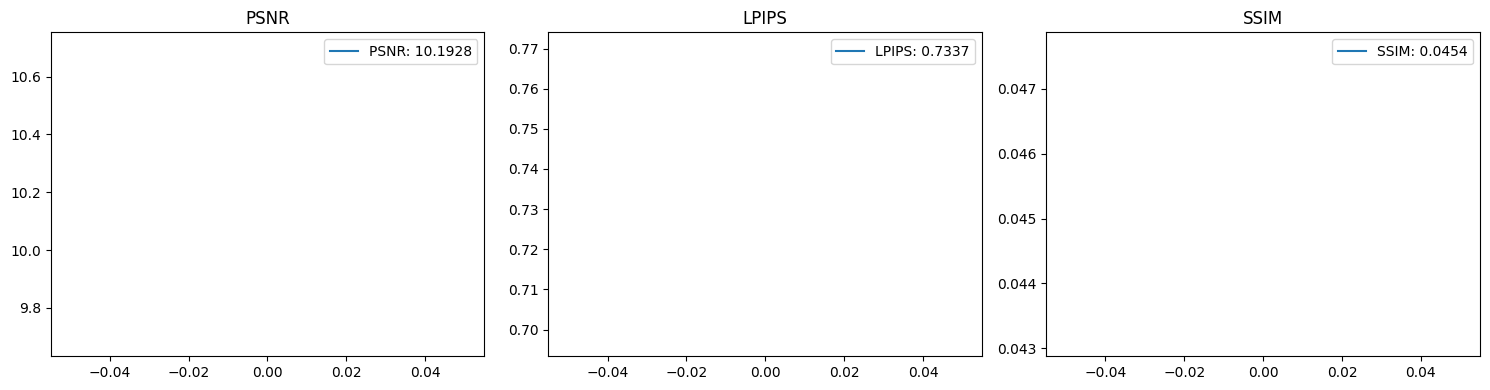

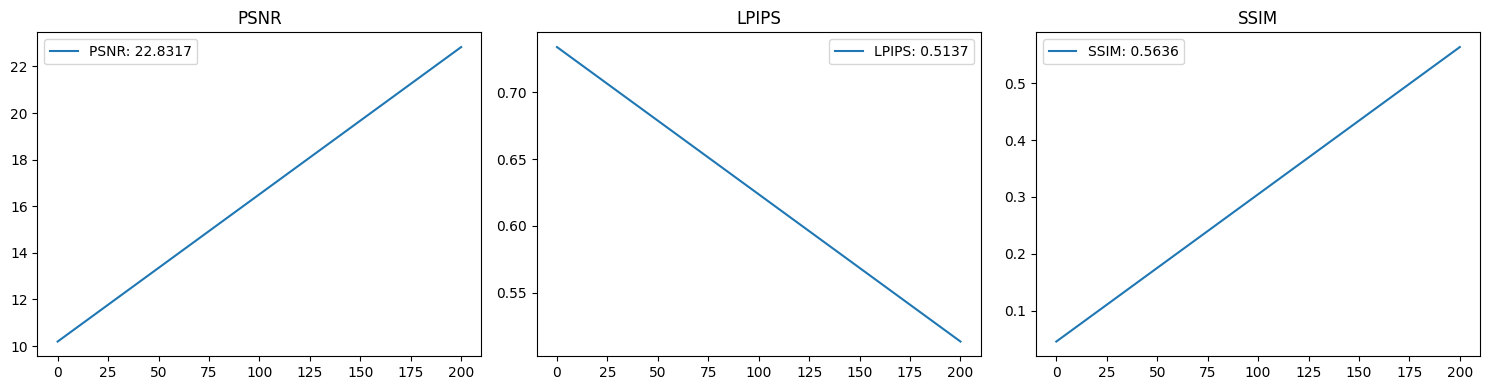

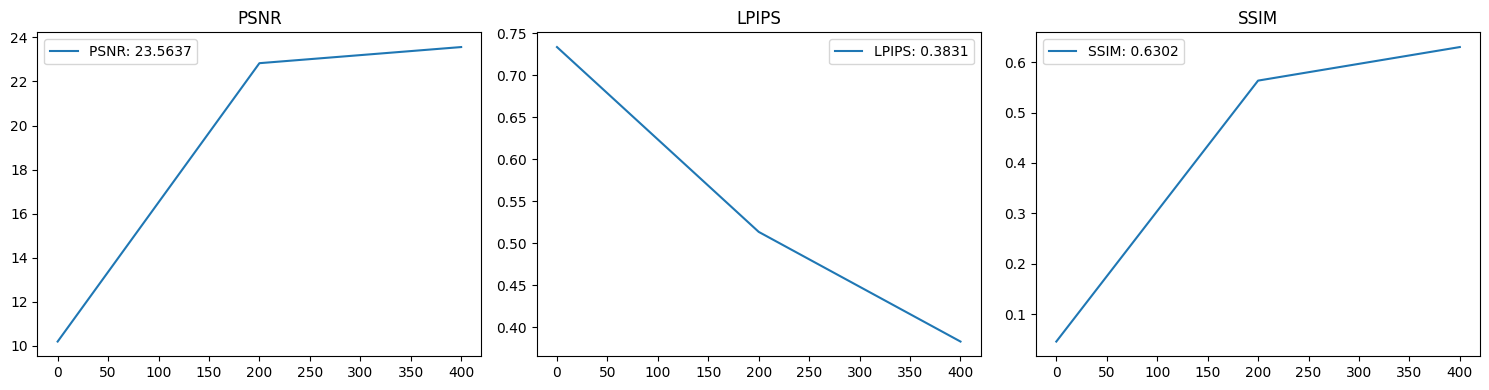

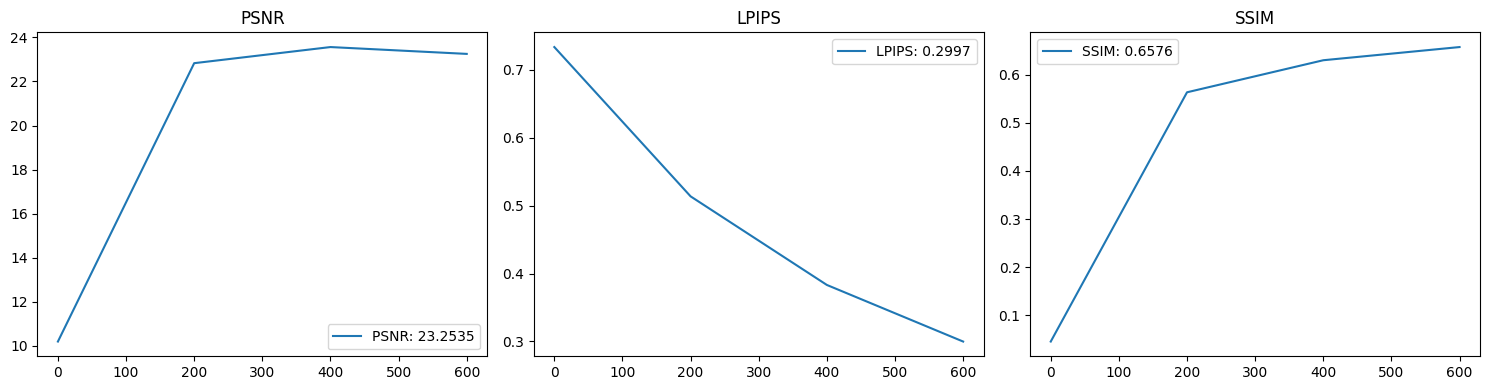

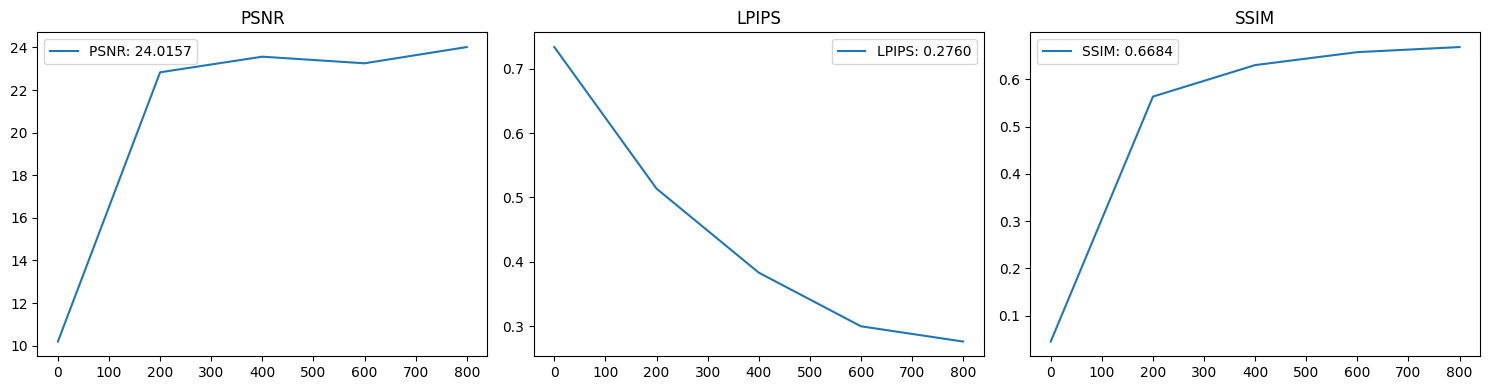

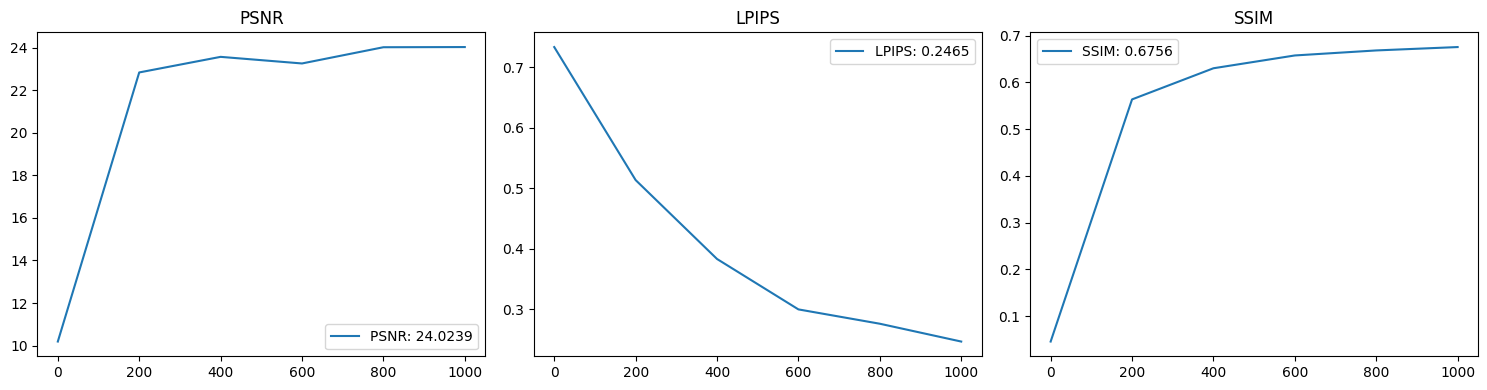

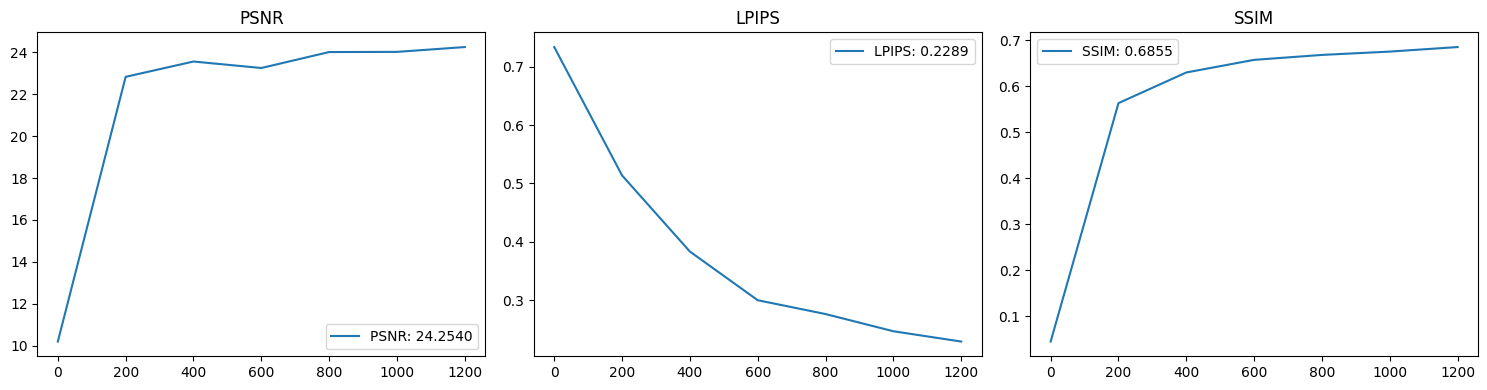

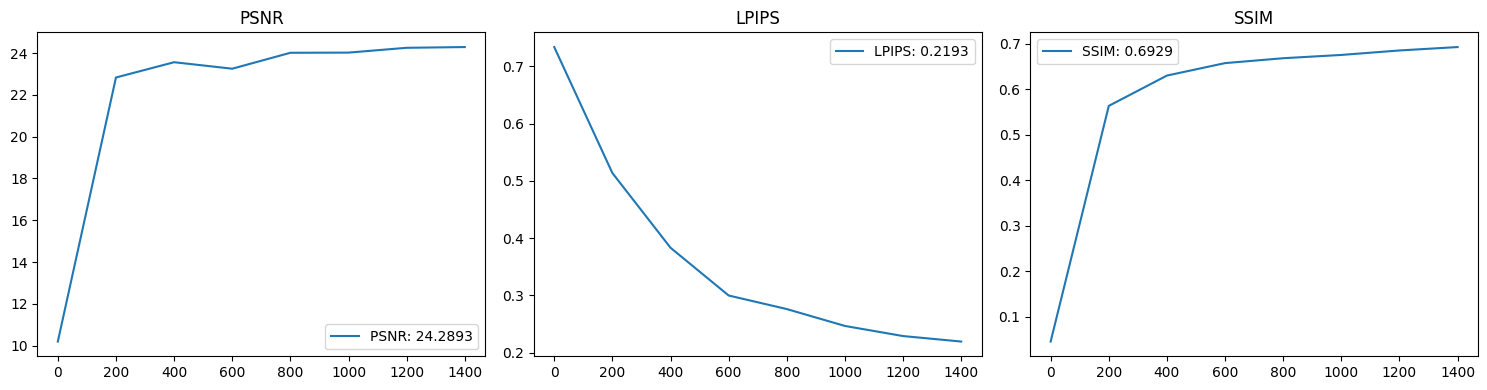

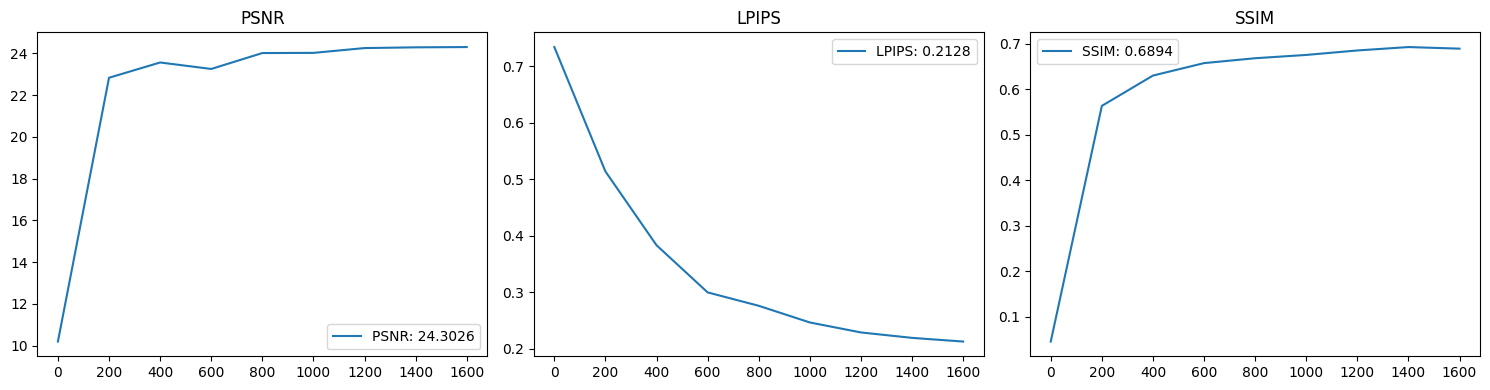

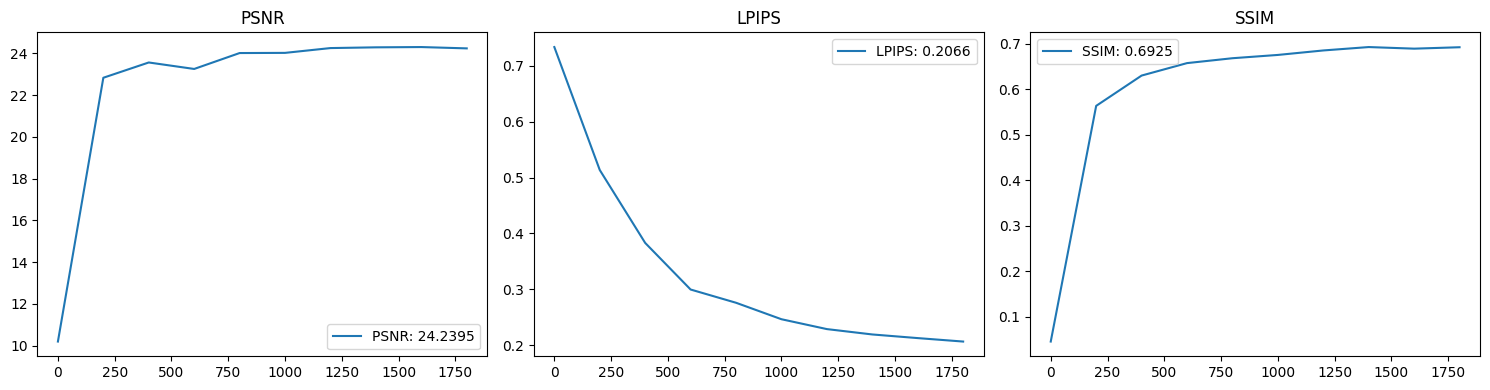

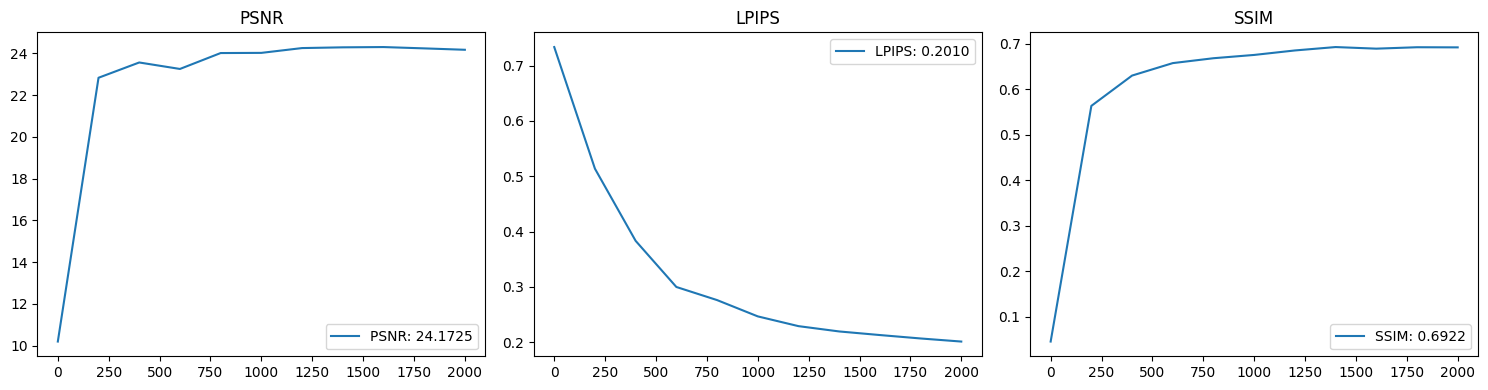

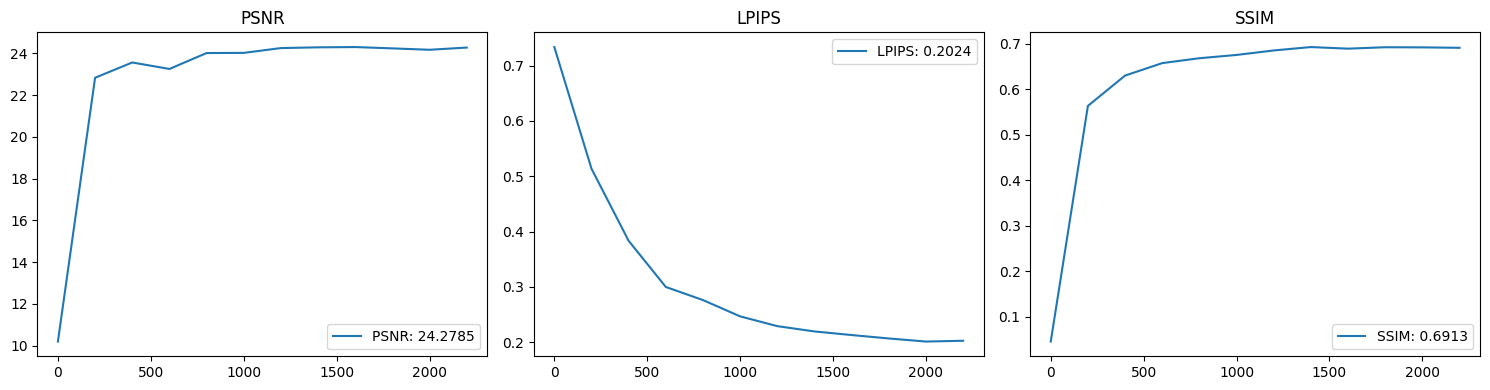

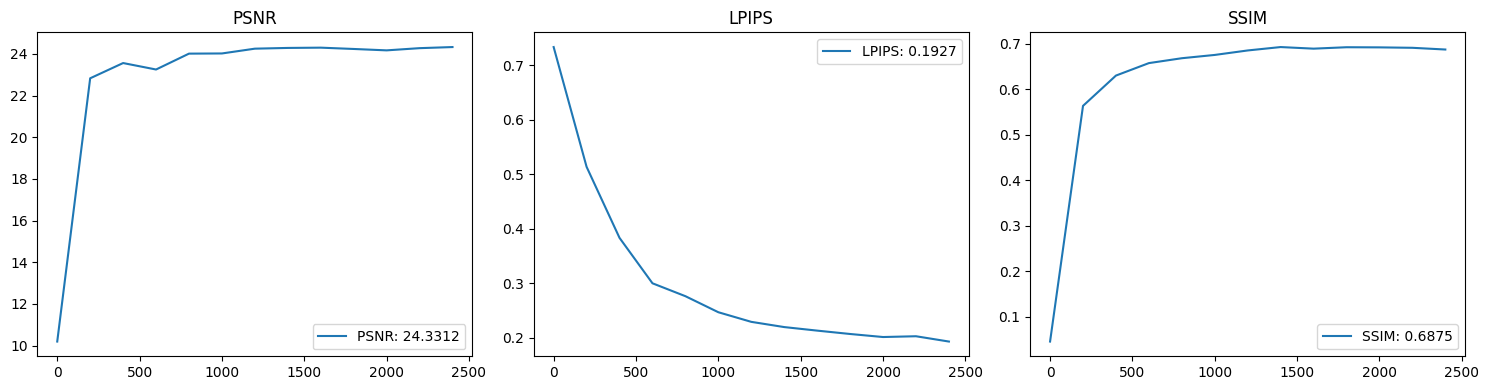

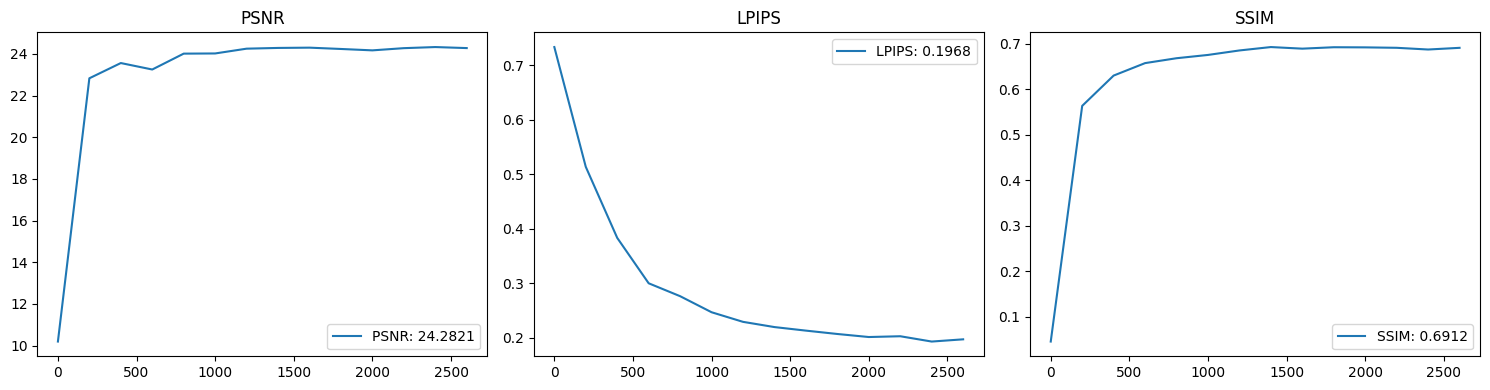

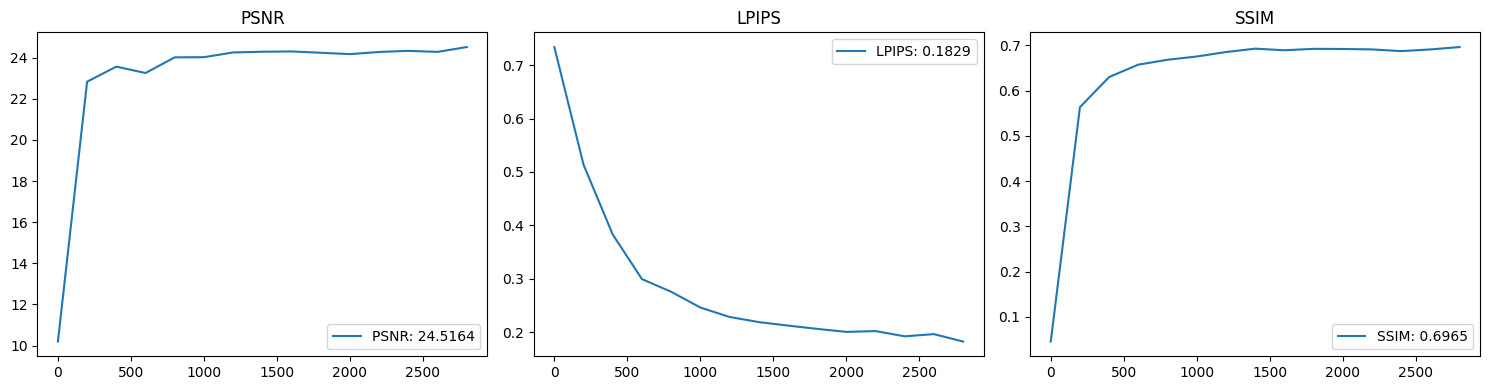

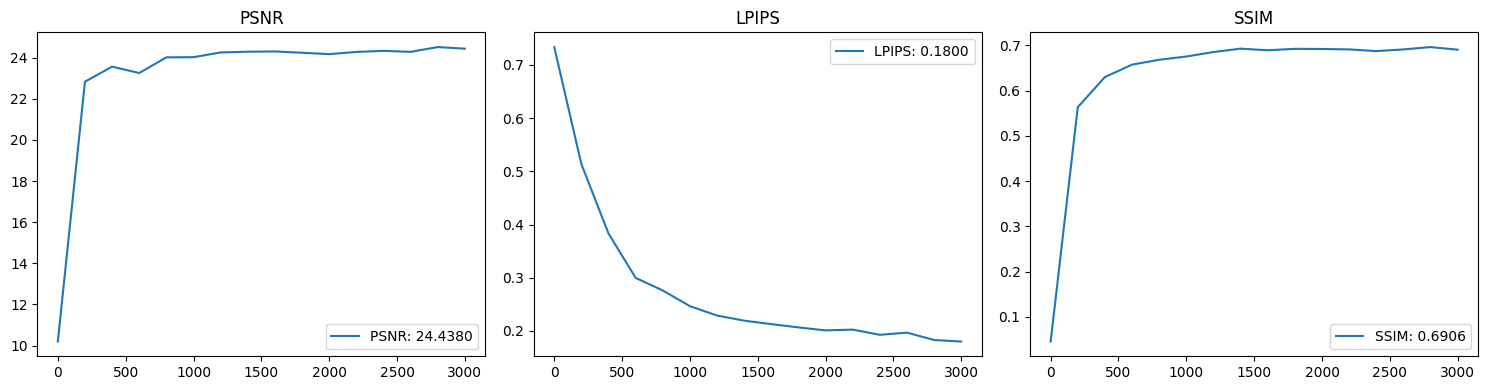

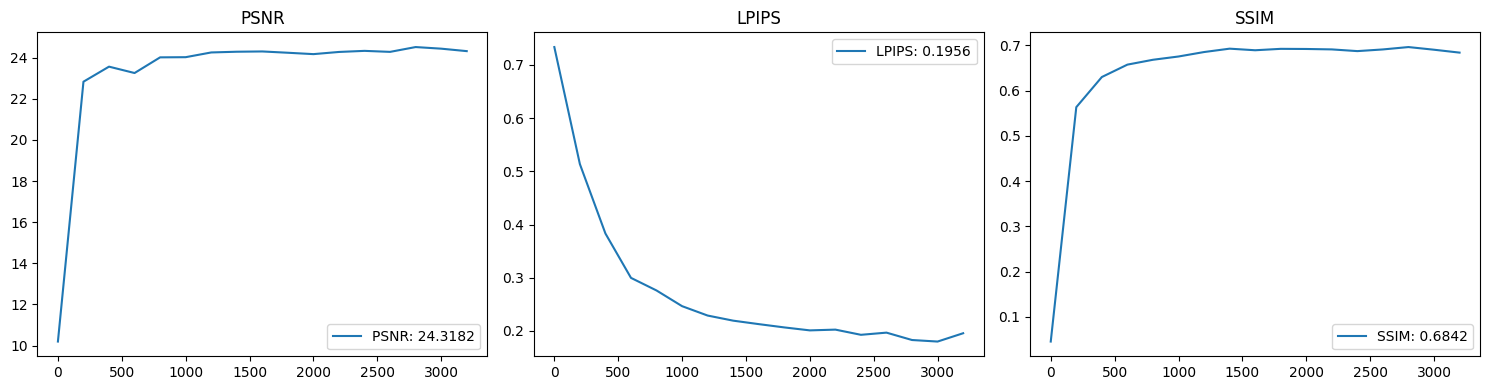

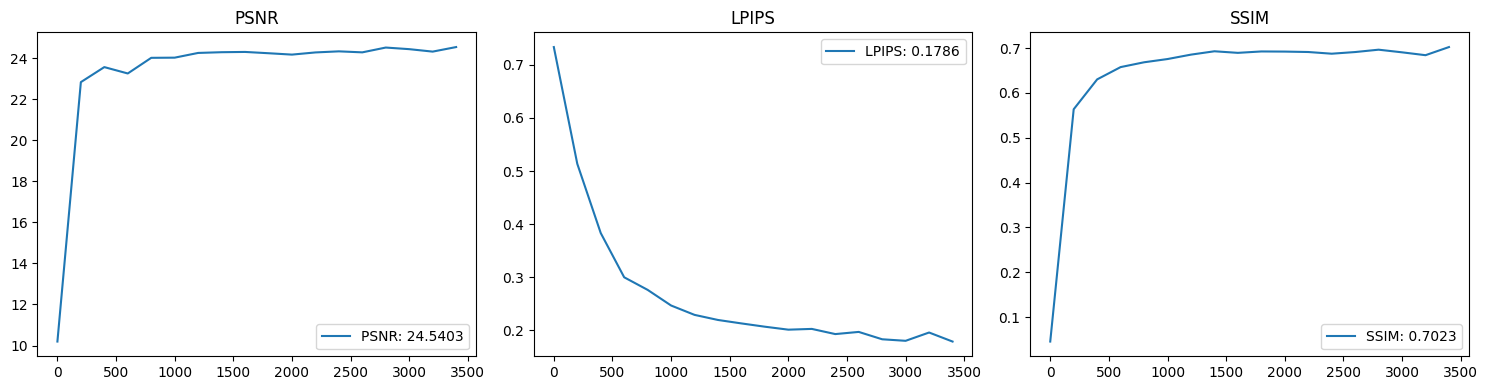

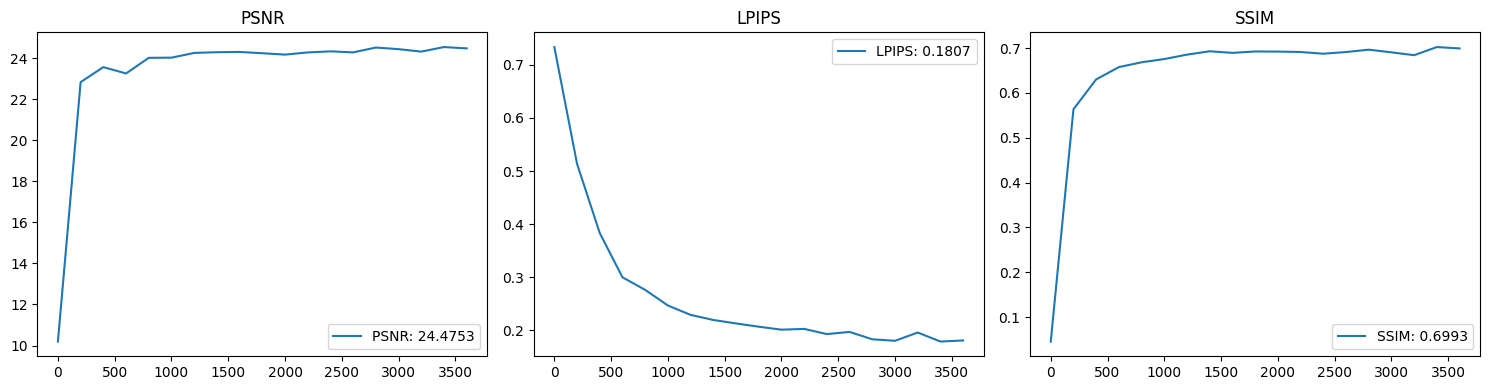

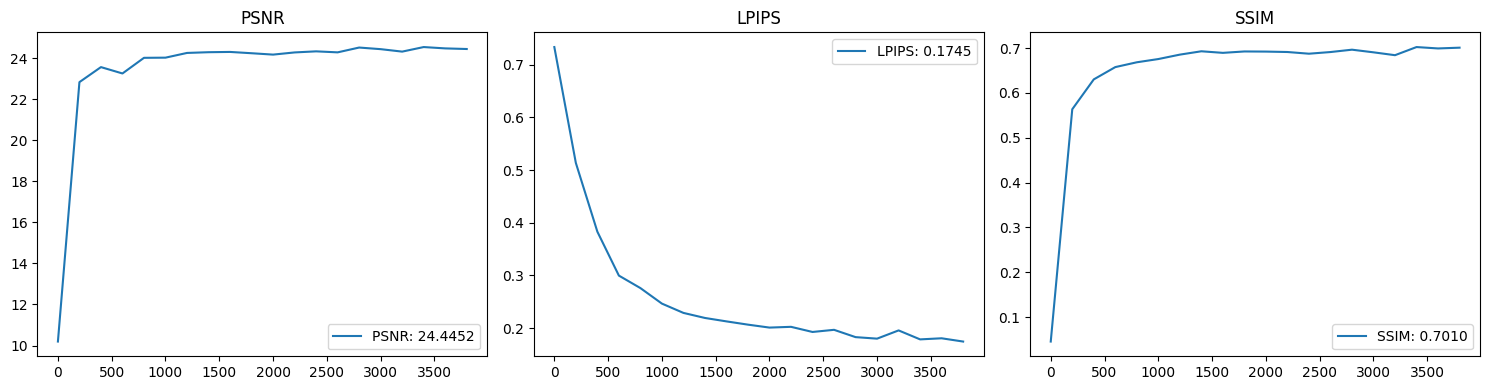

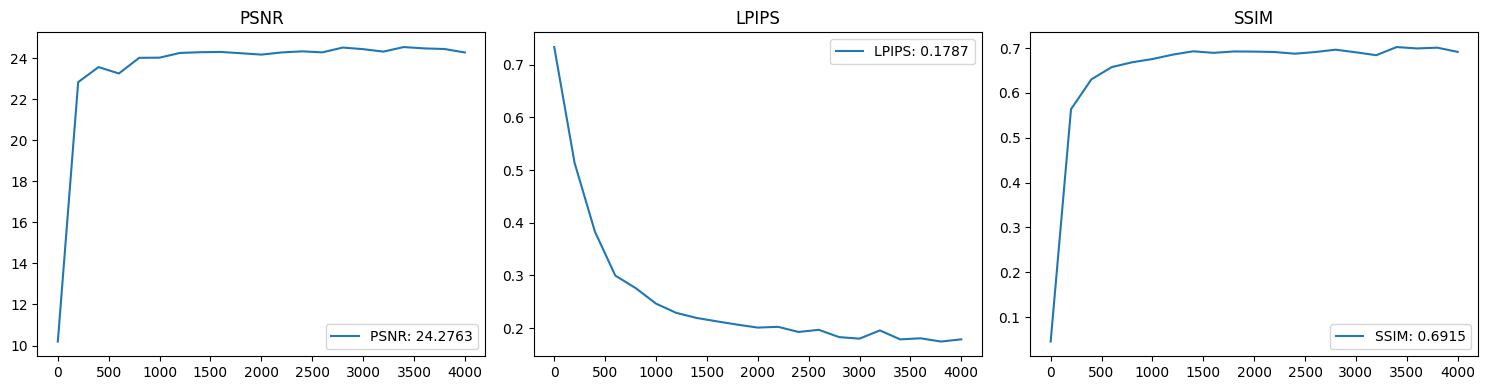

In [54]:
# List to log metric, etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)
  

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    avg_lpips = []
    avg_ssim = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

In [39]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

psnr: 21.55539741516113
lpips: 0.1516881339251995
ssim: 0.7908098936080933


Reconstructed Test Images


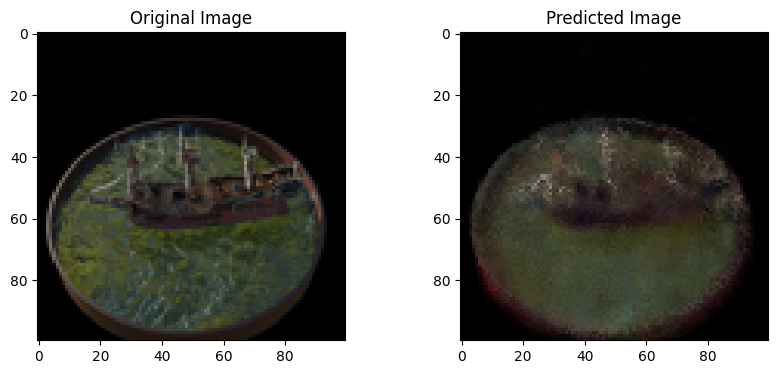

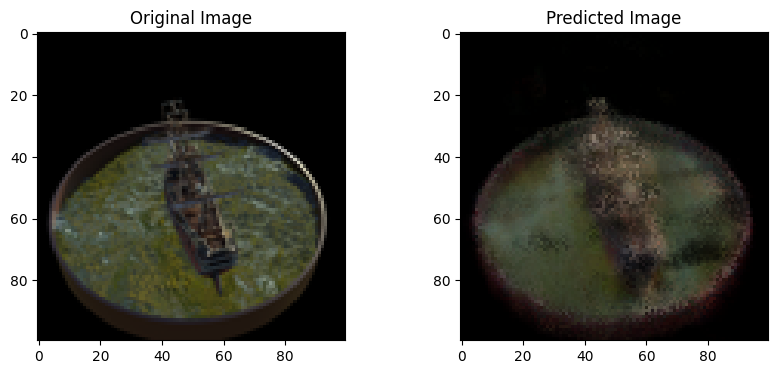

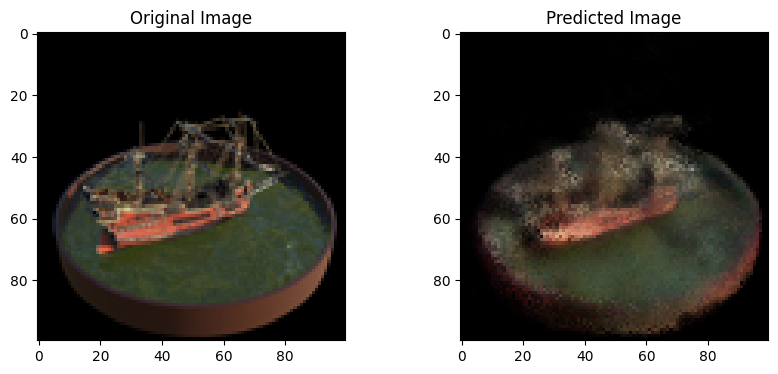

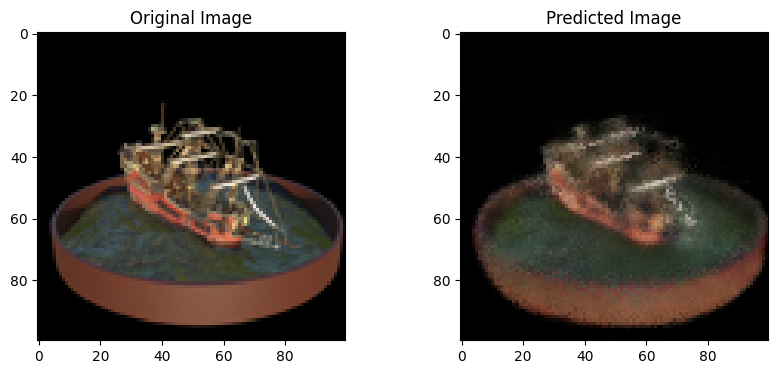

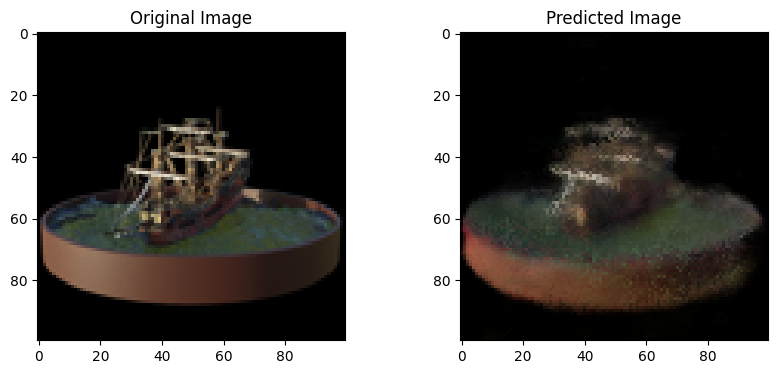

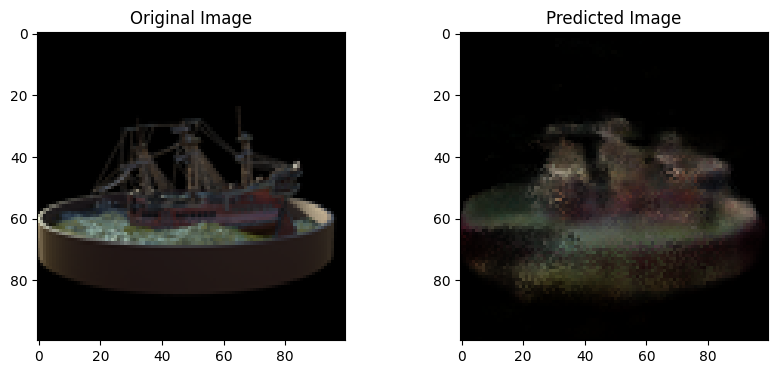

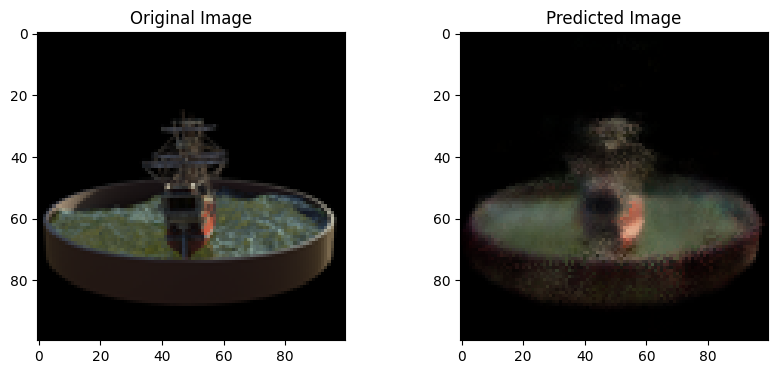

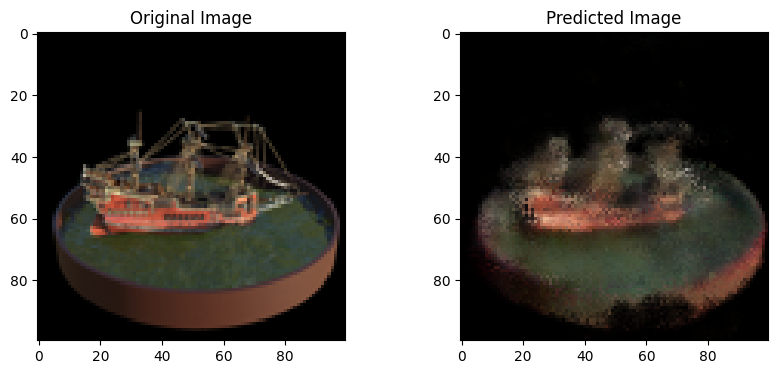

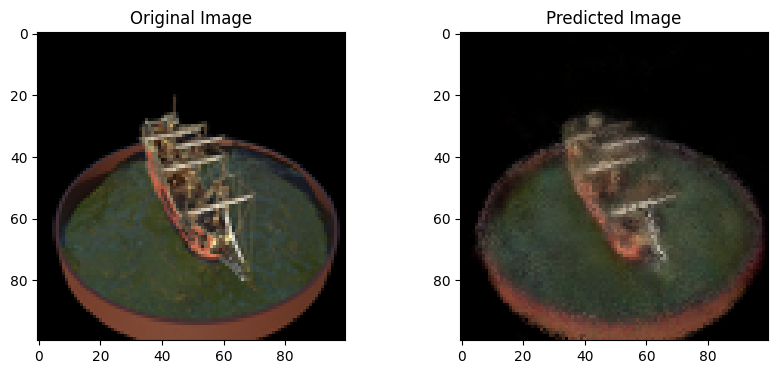

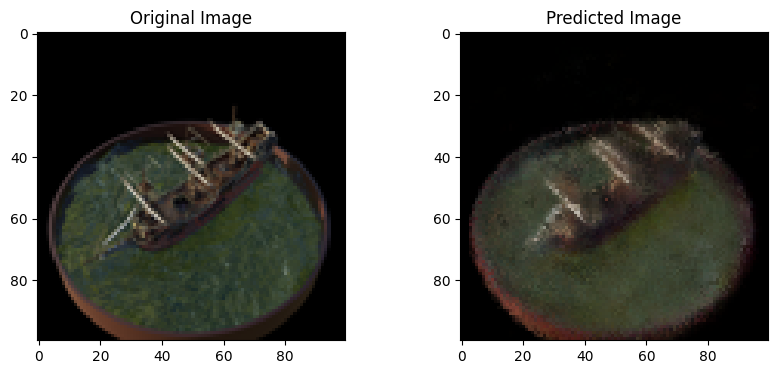

In [55]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()

# **Image Embedding Based**

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True).to(device)
        self.resnet.eval()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Adjust the dimensions to match [channels, batch_size, height, width]
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        feats1 = self.resnet.relu(x)
        feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
        feats3 = self.resnet.layer2(feats2)
        feats4 = self.resnet.layer3(feats3)
        latents = [feats1, feats2, feats3, feats4]
        output_size = (100, 100)
        for i in range(len(latents)):
            latents[i] = F.interpolate(
                latents[i], output_size, mode="bilinear", align_corners=True
            )
        latents = torch.cat(latents, dim=1)
        return latents

In [ ]:
def numpy_cosine(img1, img2):
  e1 = np.expand_dims(img1, axis=0)
  e2 = np.expand_dims(img2, axis=0)
  return 1 - cosine_similarity(e1, e2)

def extract_features(image_array):
  # Instantiate the ImageEncoder
  image_encoder = ImageEncoder()

  # Get the embeddings
  embeddings = image_encoder(image_array)

  # Perform PCA for dimensionality reduction
  #  pca = PCA(n_components=10)

  image_embd = embeddings.squeeze().contiguous().view(embeddings.size(0), -1).cpu().detach().numpy()

  # pca = PCA(n_components=5)
  umap_reducer = umap.UMAP(n_neighbors=5, n_components=5, min_dist = 0.1)

  # reduced_img_embd = pca.fit_transform(image_embd)
  reduced_img_embd = umap_reducer.fit_transform(image_embd)

  scaler = StandardScaler()
  scaled_red_img_emb = scaler.fit_transform(reduced_img_embd)

  return scaled_red_img_emb

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2, ord=2)

def get_fvs_cluster(cluster_camera_pos):
    pairwise_distances = squareform(pdist(cluster_camera_pos))
    indices = np.unravel_index(np.argmax(pairwise_distances), pairwise_distances.shape)
    return indices

def select_diverse_images_per_cluster(tform_cam2world, labels):
    """
    Select the most diverse image from each cluster based on cosine similarity.
    """
    unique_labels = set(labels)
    selected_indices = []

    for label in unique_labels:

        if label == -1:
            continue  # Skip noise

        cluster_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        cluster_camera_pos = [camera_position_from_extrinsic_matrix(transform).detach().cpu().numpy() for transform in tform_cam2world[cluster_indices]]

        if len(cluster_indices) > 1:

            pairwise_distances = squareform(pdist(cluster_camera_pos))
            indices = np.unravel_index(np.argmax(pairwise_distances), pairwise_distances.shape)
            selected_indices.append(cluster_indices[indices[0]])
            selected_indices.append(cluster_indices[indices[1]])

        else:
            selected_indices.append(cluster_indices[0])

    return selected_indices

# **Image Embedding and H/DBSCAN**

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 4000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

embeddings = extract_features(images)
#labels = DBSCAN(eps=0.7, min_samples=3).fit_predict(embeddings)
labels = HDBSCAN(min_cluster_size=6, min_samples=2).fit_predict(embeddings)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]



Frames Chosen by Image Embeddings + HDBScan



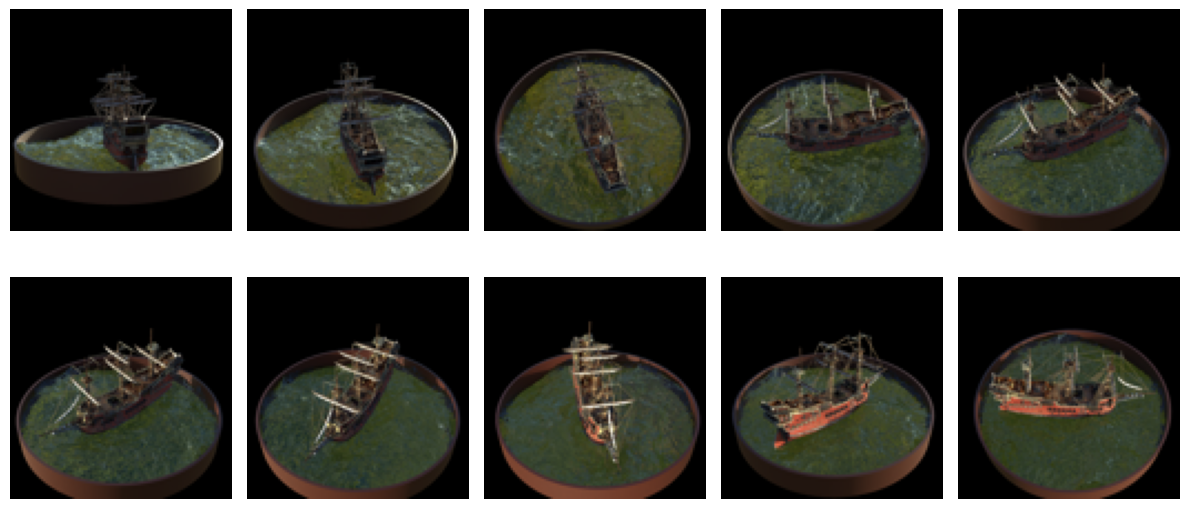

In [ ]:
diverse_indices = select_diverse_images_per_cluster(tform_cam2world, labels)

training_images = images[diverse_indices]
training_tforms = tform_cam2world[diverse_indices]

print()
print("Frames Chosen by Image Embeddings + HDBScan")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

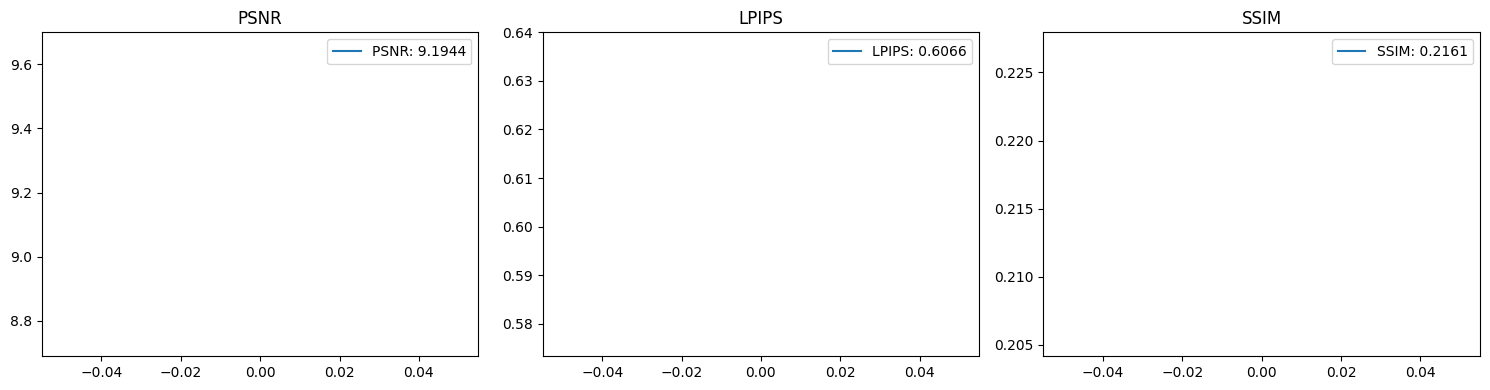

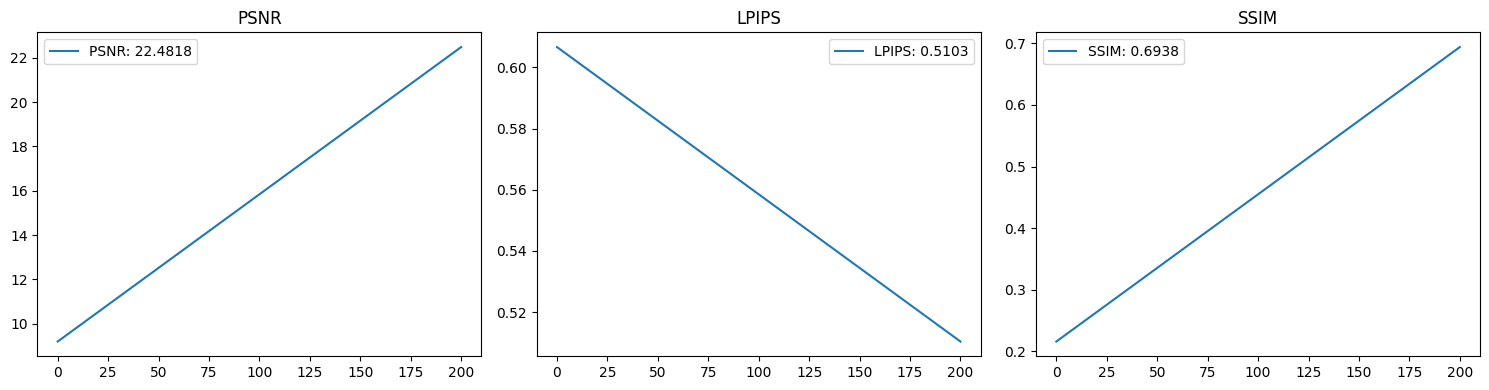

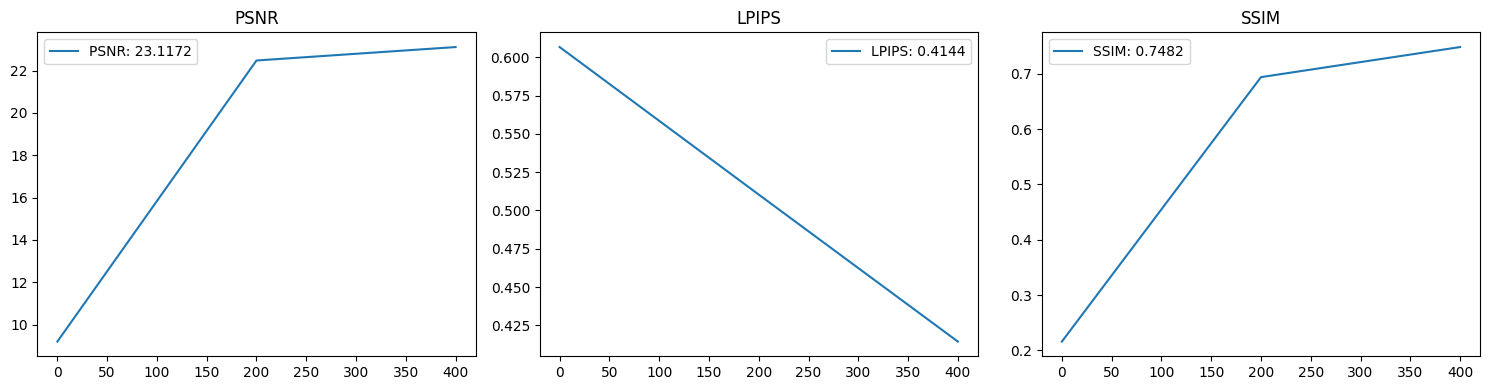

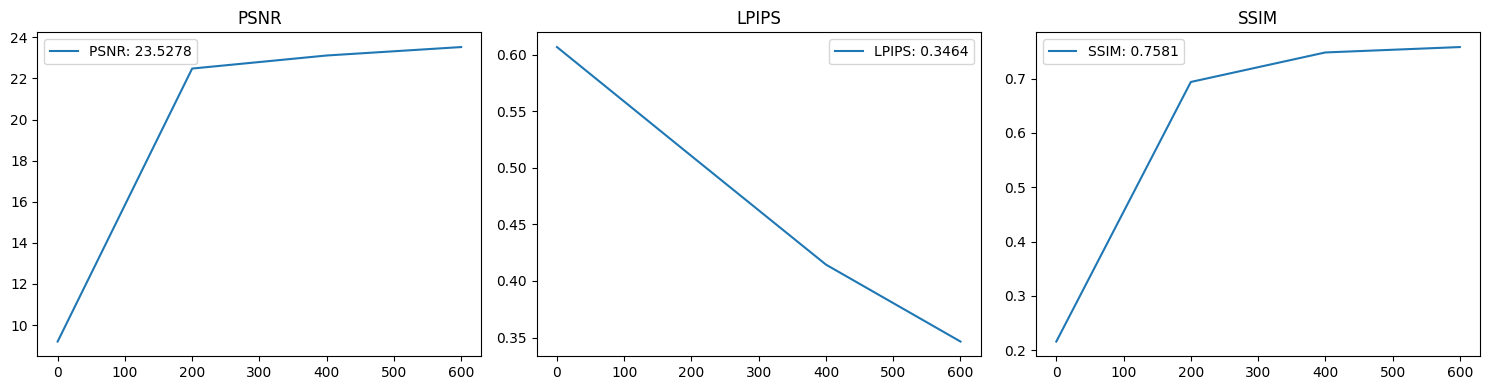

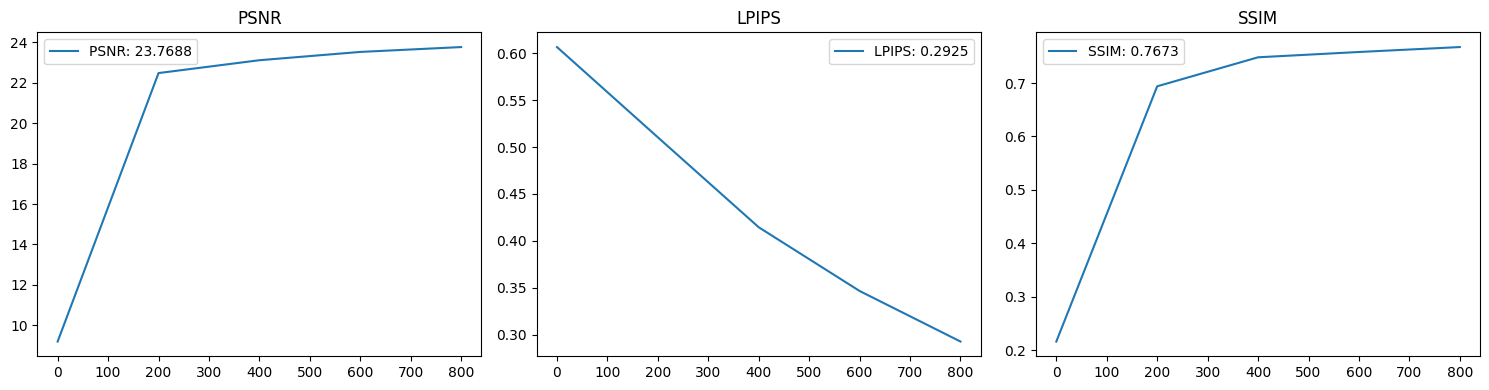

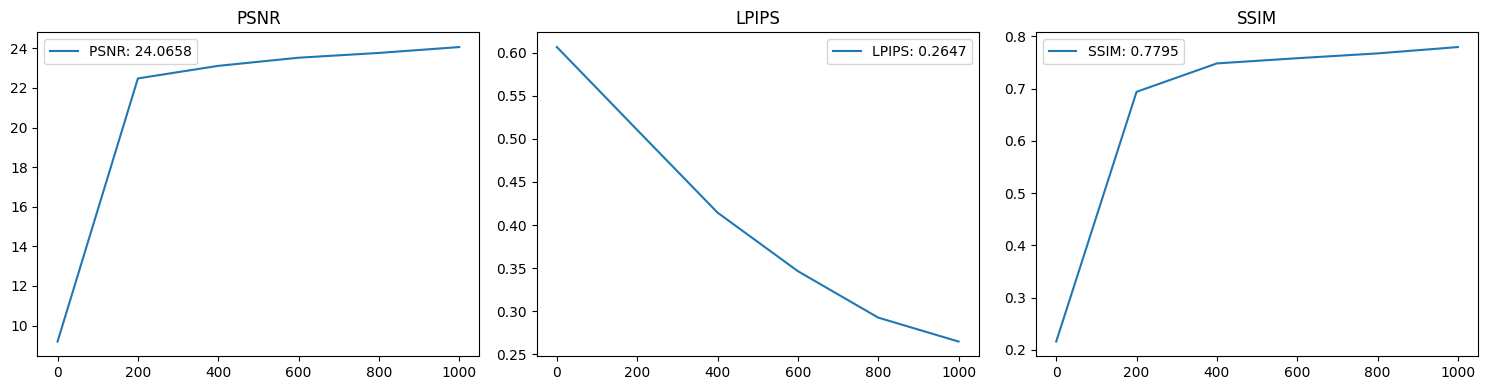

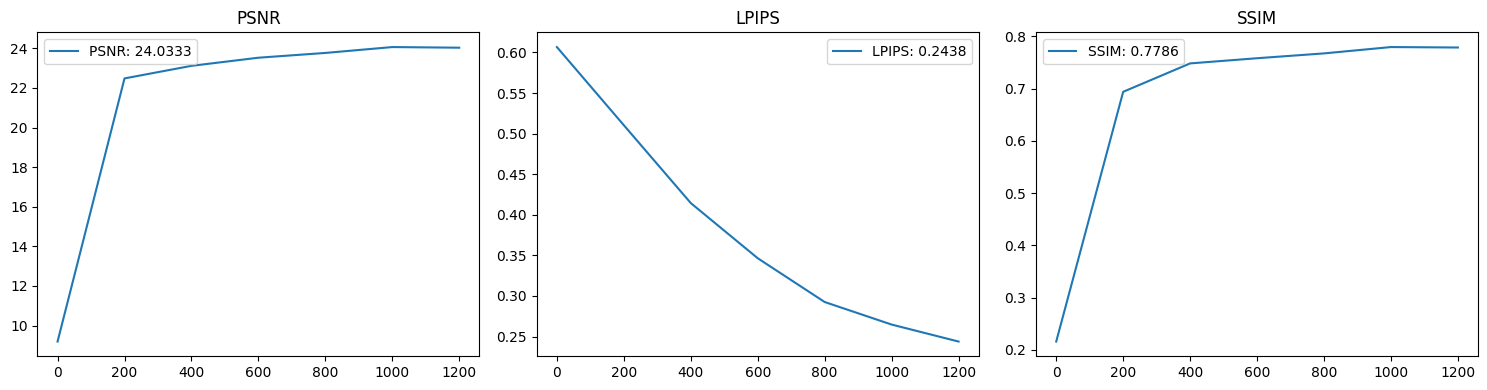

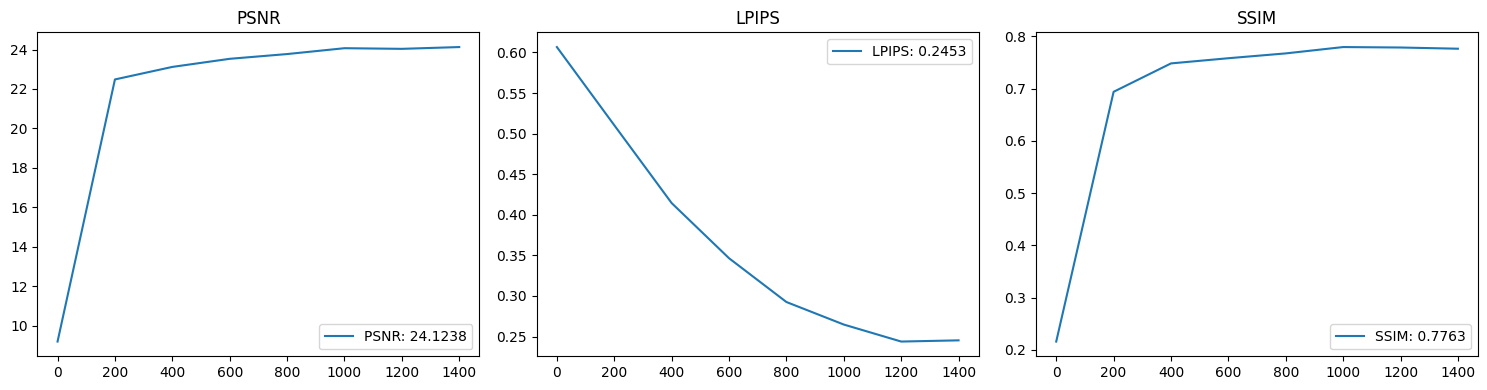

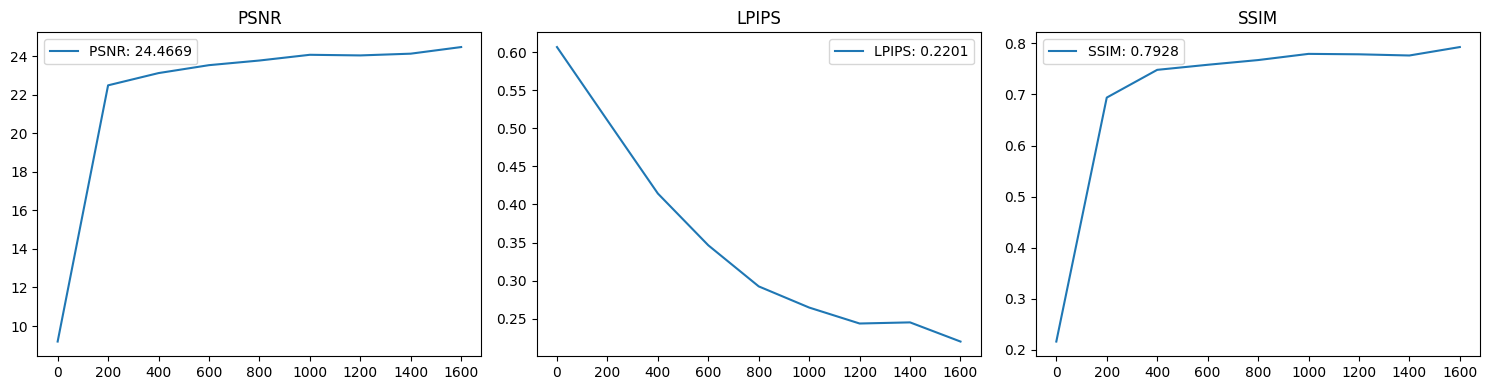

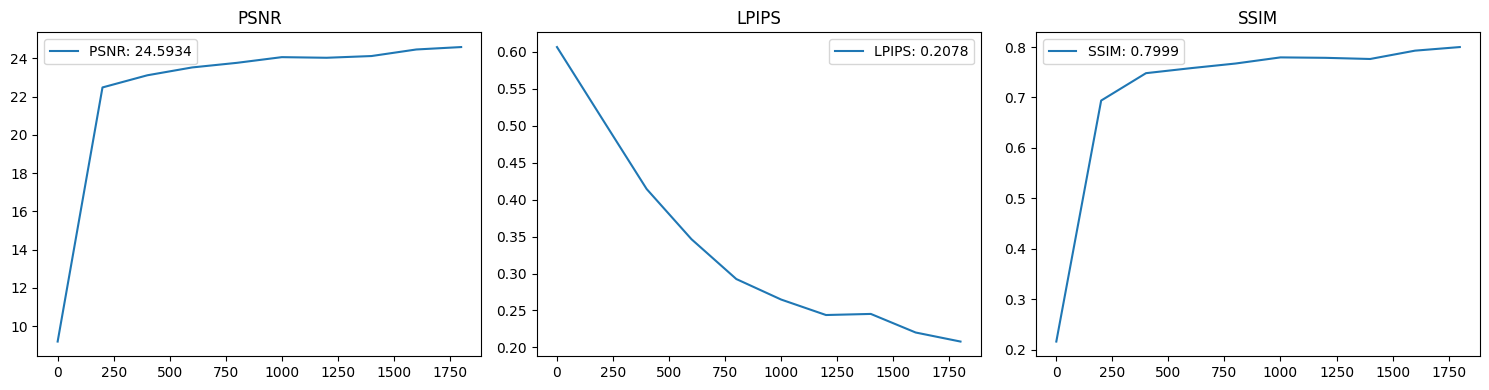

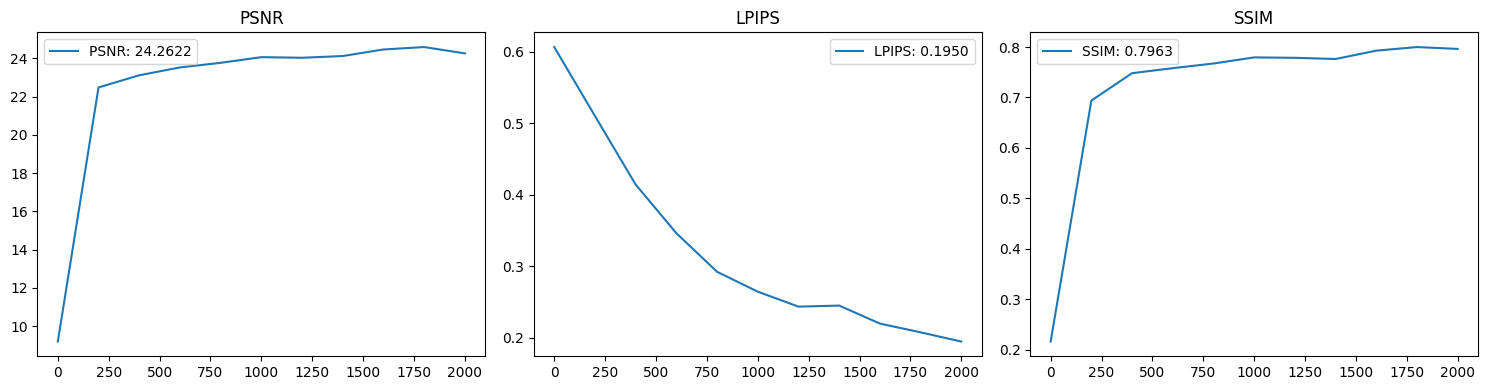

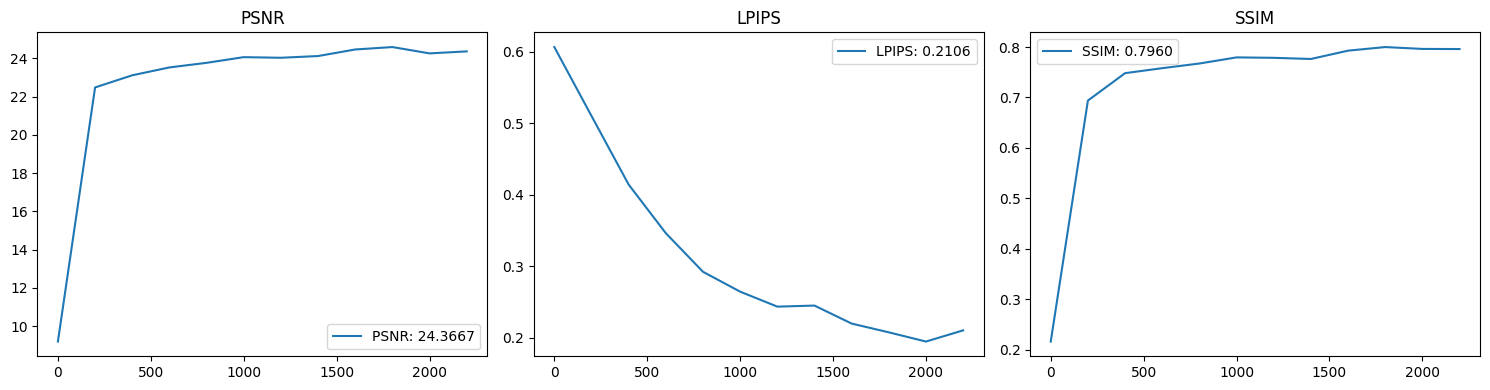

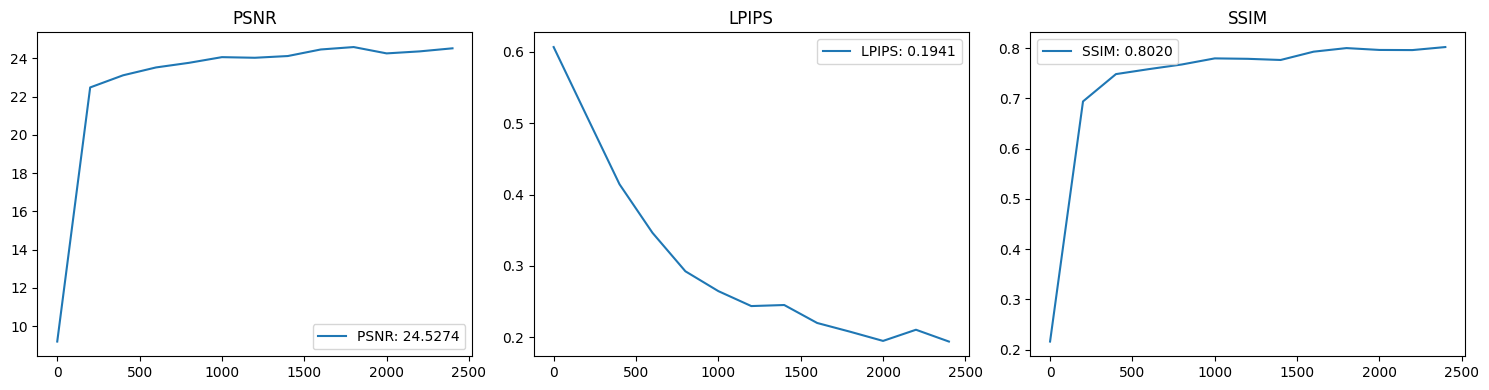

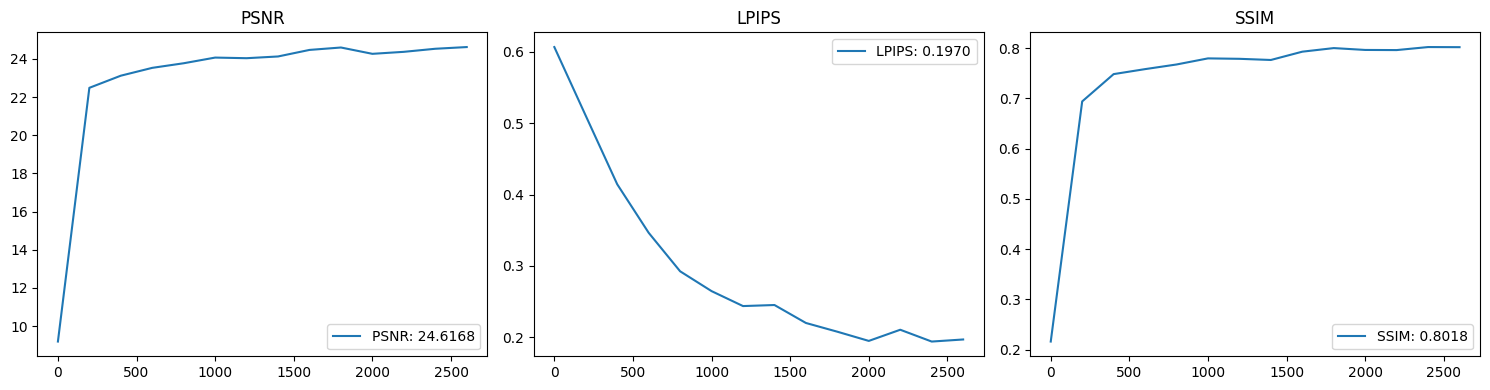

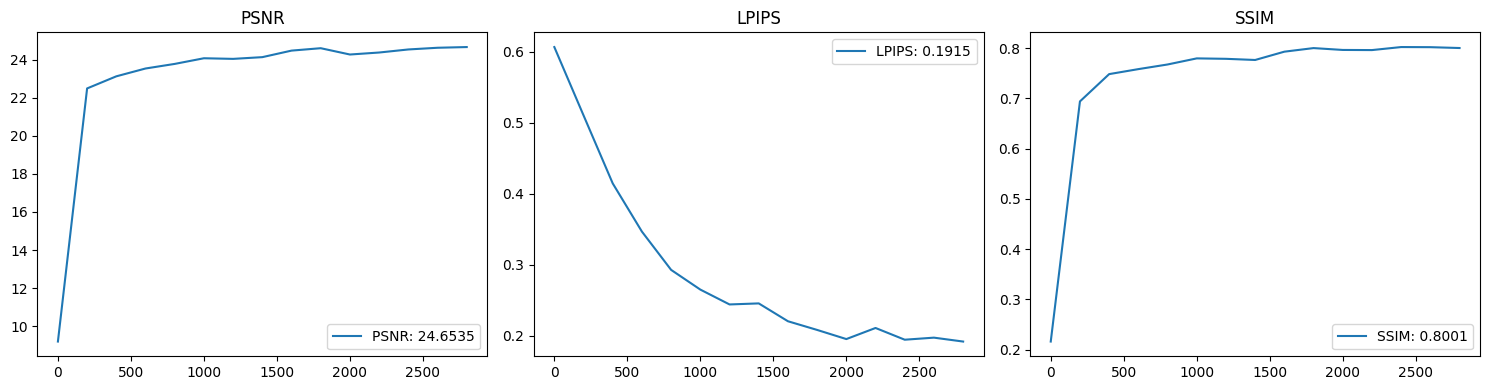

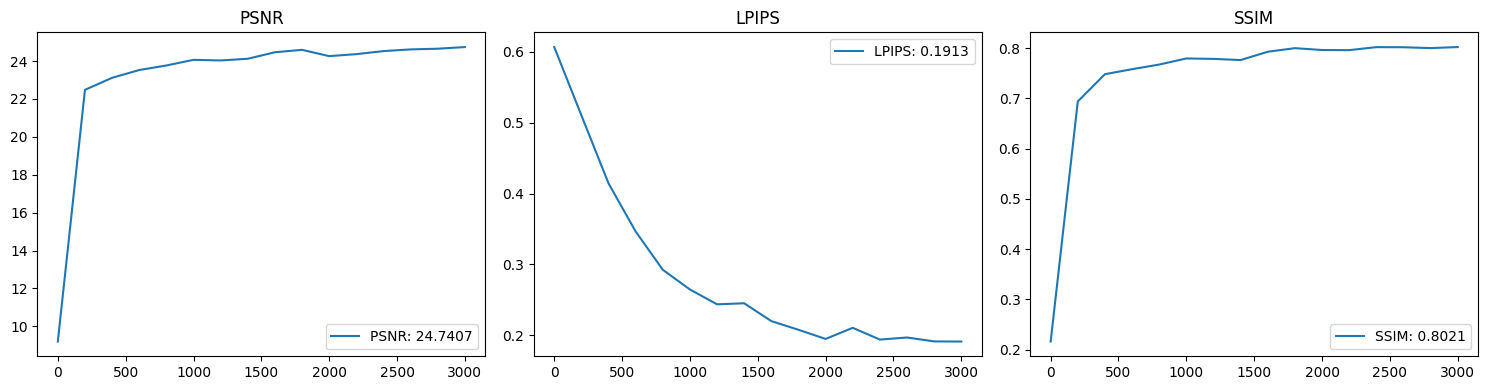

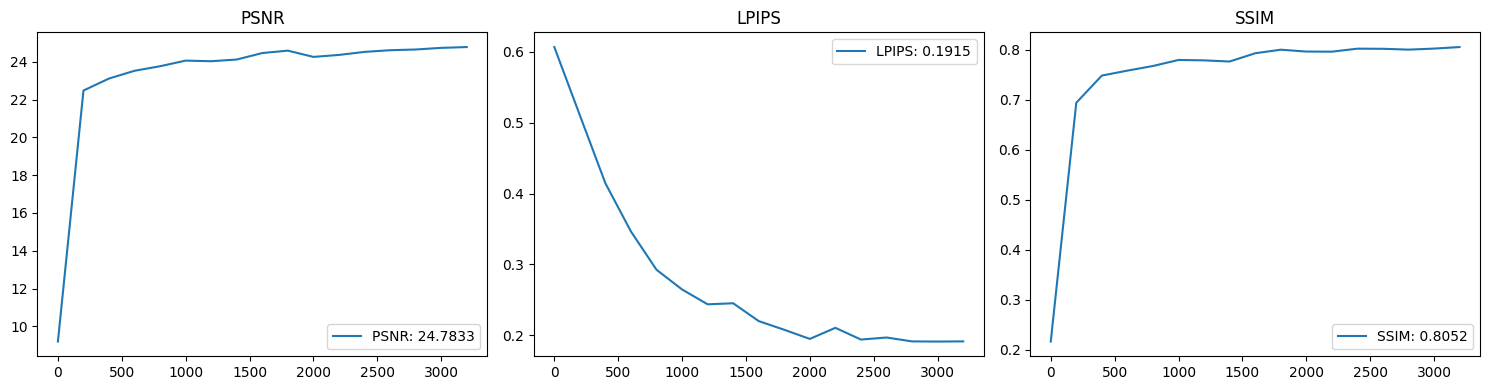

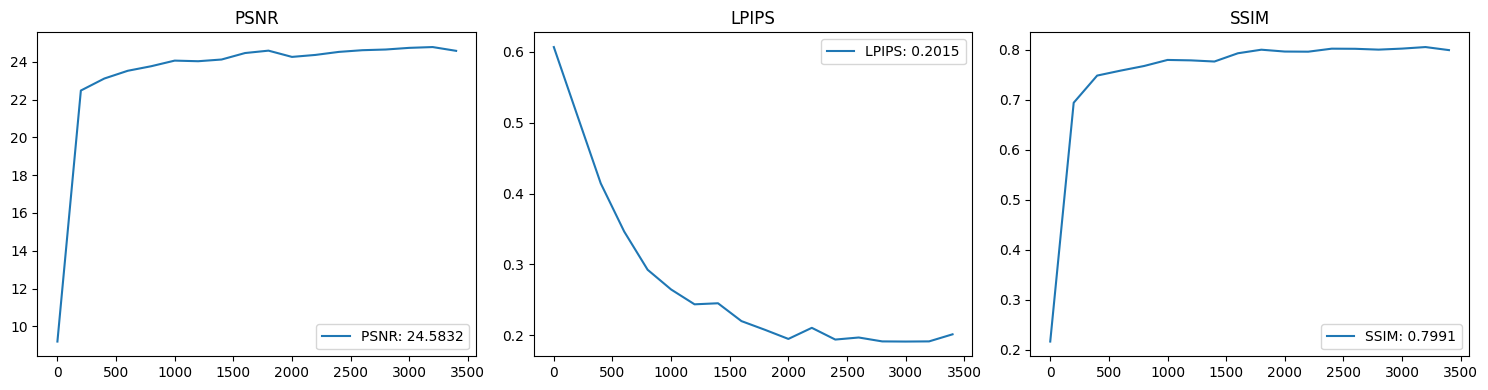

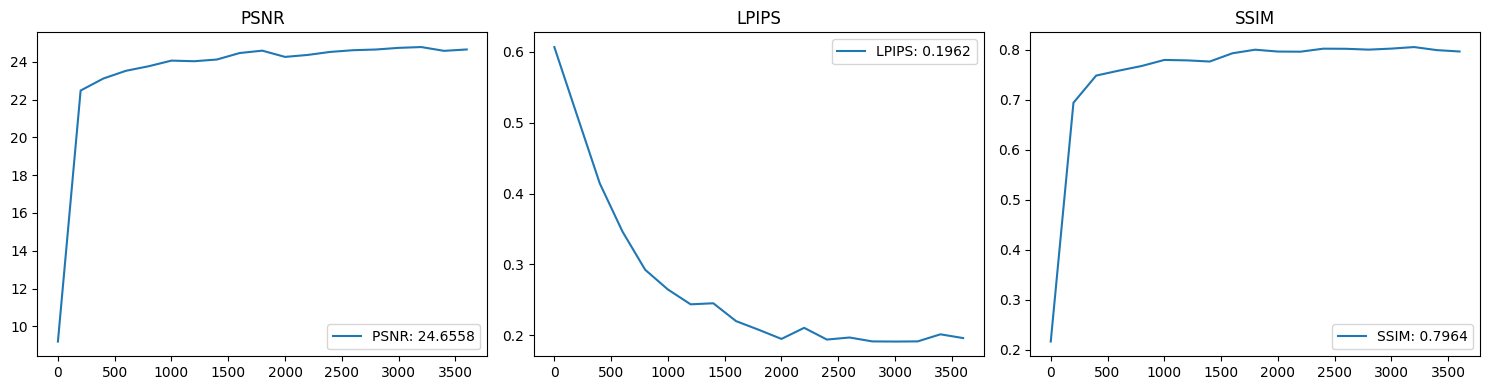

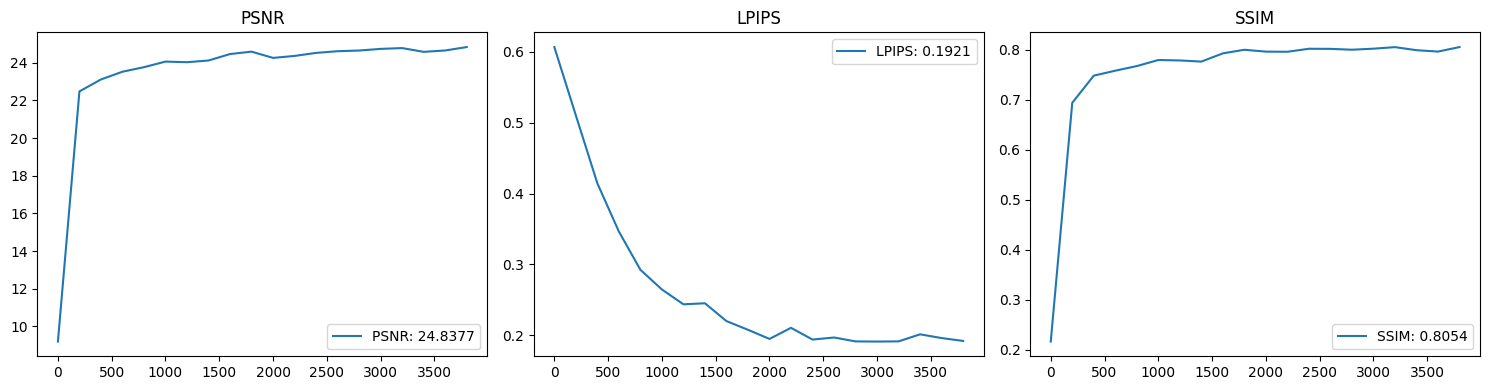

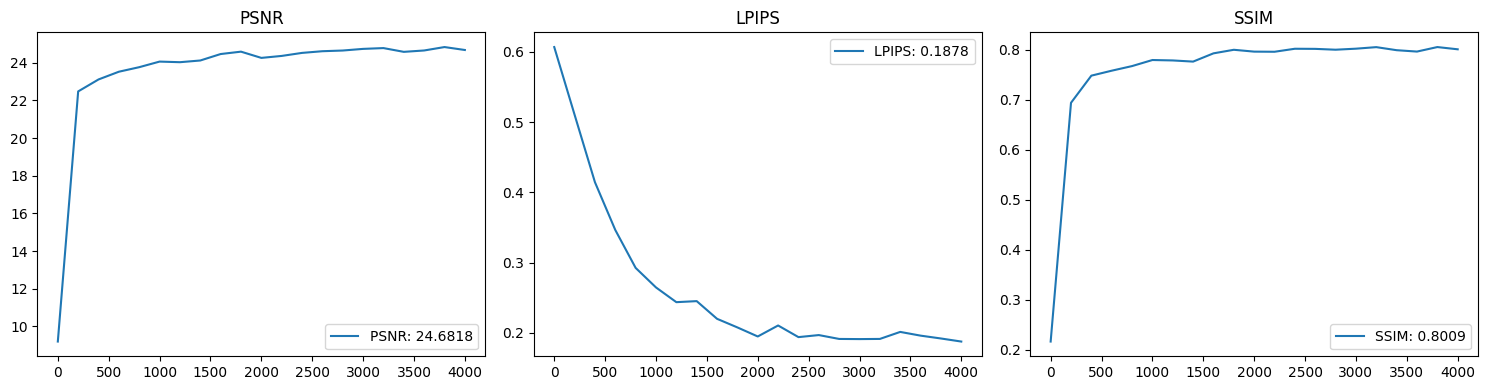

Done!


In [ ]:
# Lists to log metrics etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    avg_lpips = []
    avg_ssim = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

print('Done!')

In [ ]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

psnr: 24.68178653717041
lpips: 0.18775635659694673
ssim: 0.800907951593399


Reconstructed Test Images


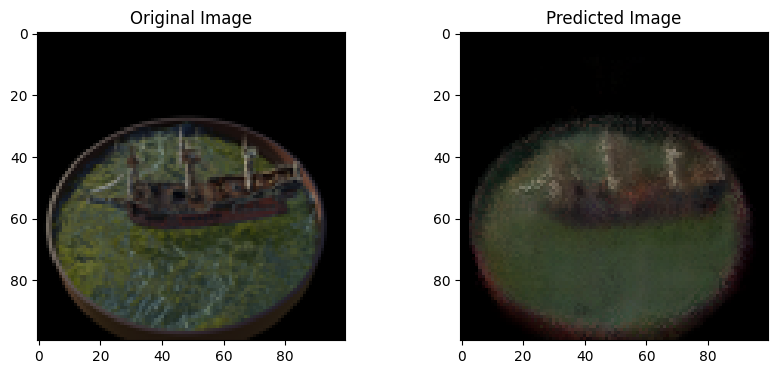

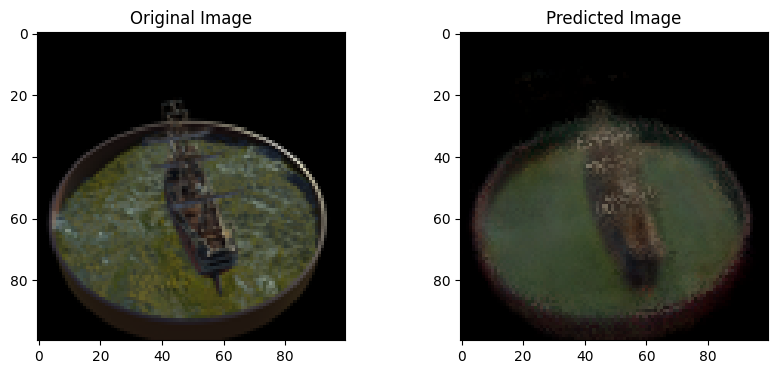

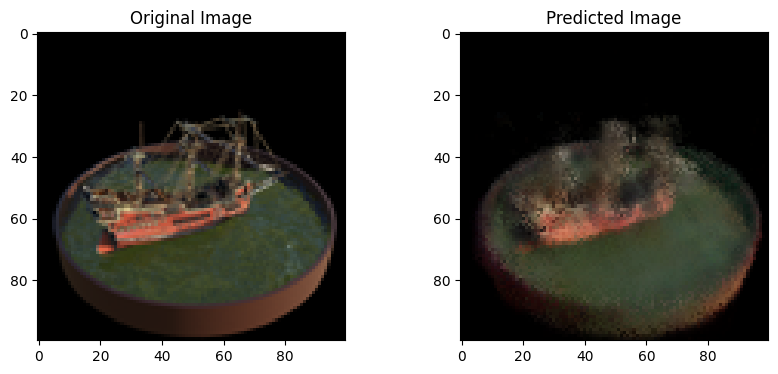

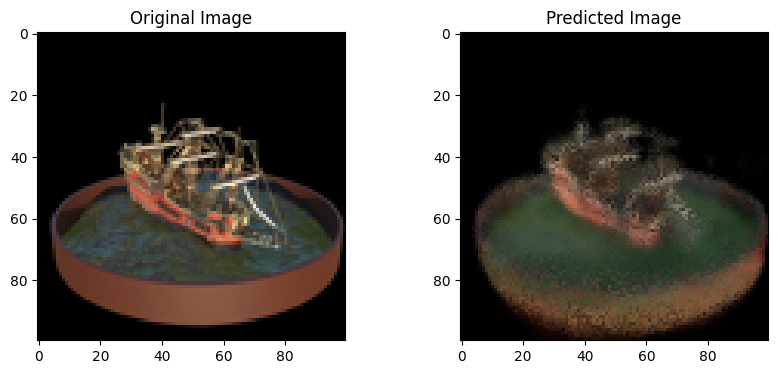

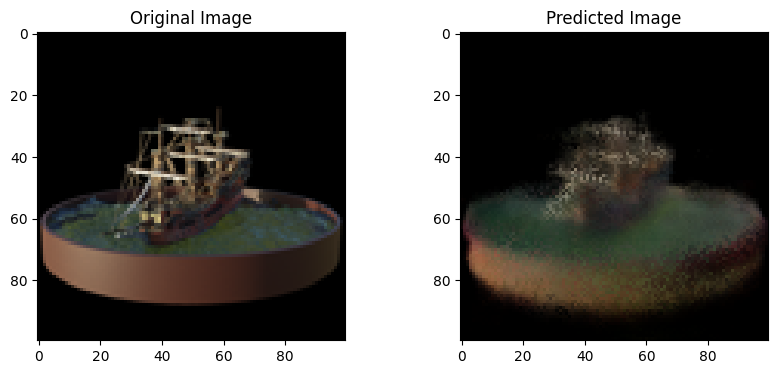

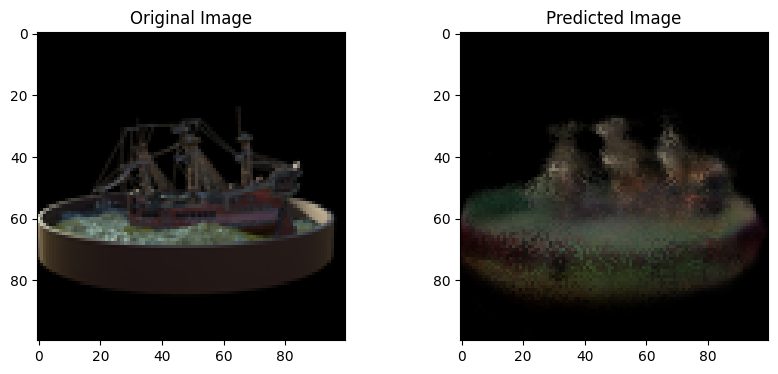

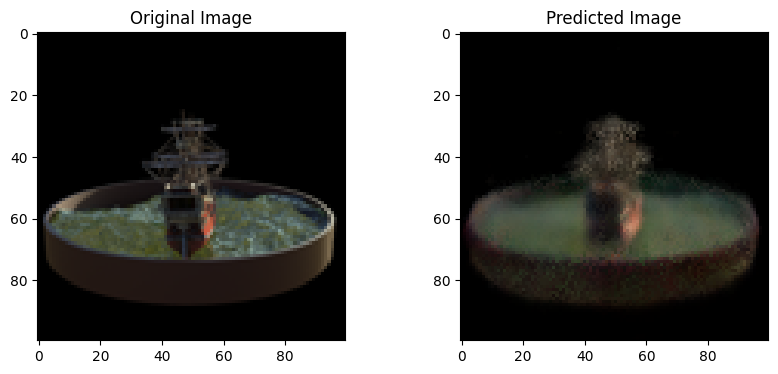

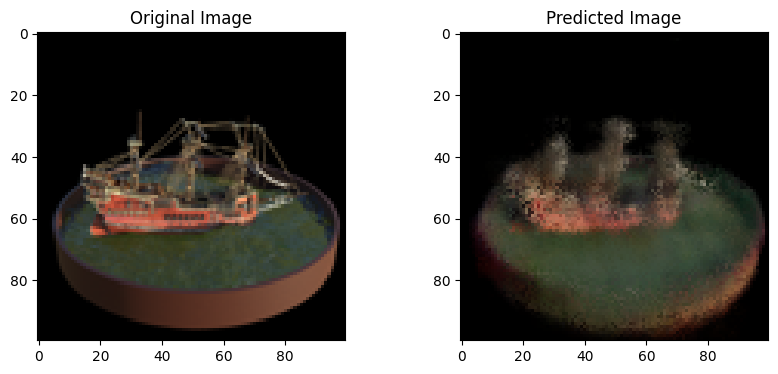

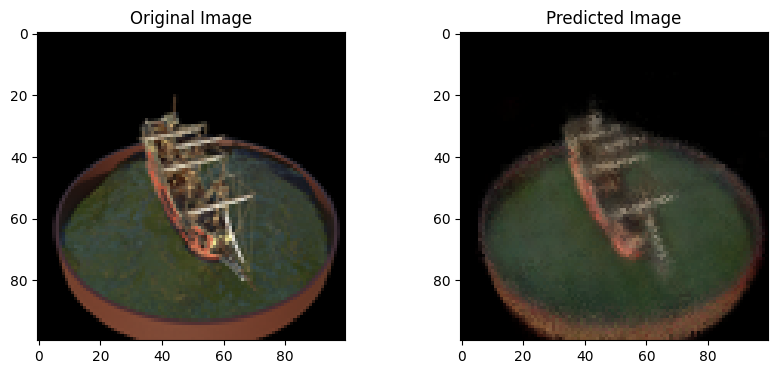

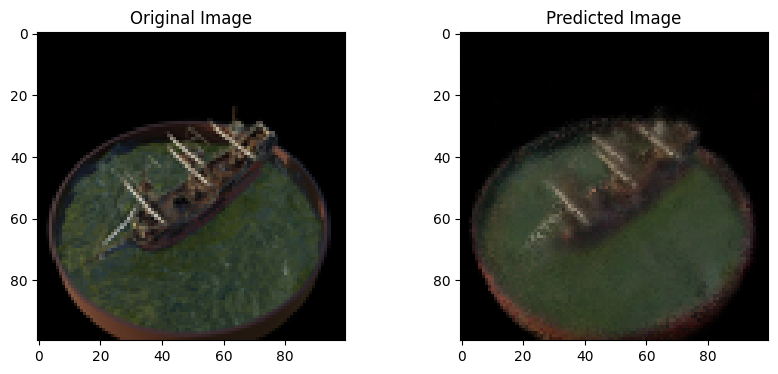

In [ ]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()